In [18]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
%autoreload 1

In [20]:
%aimport helpers, loaders, plotters

In [21]:
from pprint import pprint
from math import ceil
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from helpers import load_best_result, save_search_result, scikit_cv_result_to_df
from loaders import load_adult, load_mnist
from plotters import plot_means_w_stds, gen_and_plot_learning_curve, plot_learning_curve, gen_and_plot_validation_curve, plot_validation_curve

### Load Data

In [5]:
dataset = 'adult'
learner_type = 'ANN'
loader_func = load_adult

In [6]:
df = loader_func(preprocess=True)

### Split data into training and testing

In [7]:
from sklearn.model_selection import train_test_split

X = df[[c for c in df.columns if c != 'target']]
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)

### Scale Data

In [8]:
# Use min max scaling because input dataset is sparse, i.e. mostly zeros
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Neural Nets

In [9]:
# Build a KerasClassifier for use with scikit-learn
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD
from keras.wrappers.scikit_learn import KerasClassifier


n_features = X_train.shape[1]


def build_keras_clf(hidden_layer_sizes=(10,10), learning_rate_init=0.01, momentum=0.8):
    """This function builds a Keras model for use with scikit's GridSearch"""
    if not isinstance(hidden_layer_sizes, tuple):
        hidden_layer_sizes = (hidden_layer_sizes,)
    
    model = Sequential()
    
    model.add(Dense(units=n_features, input_shape=(n_features,), activation='relu'))
    
    for layer_size in hidden_layer_sizes:
        assert layer_size > 0
        model.add(Dense(units=layer_size, activation='relu'))
    
    # Add output layer
    model.add(Dense(units=1, activation='sigmoid'))
        
    sgd = SGD(lr=learning_rate_init, momentum=momentum, nesterov=True)
    model.compile(loss='mean_squared_error', optimizer=sgd, metrics=["accuracy"])
    
    return model

clf = KerasClassifier(build_fn=build_keras_clf)

Using TensorFlow backend.


### GridSearch for model complexity curves

In [13]:
layer_sizes = [
#     1,
#     10,
#     100,
#     (1,1),
    (10,10),
    (100,100)
]

param_grid = {
    'hidden_layer_sizes': layer_sizes,
#     'learning_rate_init': [.05, .1, .2],
#     'momentum': [0.7, 0.8, 0.9],
    'epochs': [1, 10, 100, 200],
#     'batch_size': [32, 64, 128]
}

In [14]:
grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring='accuracy',
    return_train_score=True,
    cv=4,
    verbose=0,
    n_jobs=-1,
)

In [15]:
grid_search.fit(X_train_scaled, y_train)

Epoch 1/1
15834/15834 [==============================] - 1s 33us/step - loss: 0.1569 - acc: 0.7778
Epoch 1/1
15835/15835 [==============================] - 1s 34us/step - loss: 0.1569 - acc: 0.7651
Epoch 1/1
15835/15835 [==============================] - 1s 34us/step - loss: 0.1566 - acc: 0.7678
Epoch 1/1
15835/15835 [==============================] - 1s 35us/step - loss: 0.1756 - acc: 0.7416
Epoch 1/1
15834/15834 [==============================] - 1s 41us/step - loss: 0.1543 - acc: 0.7671
Epoch 1/1
15835/15835 [==============================] - 1s 48us/step - loss: 0.1538 - acc: 0.7752
Epoch 1/1
15835/15835 [==============================] - 1s 43us/step - loss: 0.1583 - acc: 0.7678
Epoch 1/1
15835/15835 [==============================] - 1s 45us/step - loss: 0.1584 - acc: 0.7645
Epoch 1/10
15834/15834 [==============================] - 1s 38us/step - loss: 0.1707 - acc: 0.7752
Epoch 2/10
15834/15834 [==============================] - 0s 30us/step - loss: 0.1277 - acc: 0.8208
Epoch 3/

15835/15835 [==============================] - 1s 35us/step - loss: 0.1174 - acc: 0.8315
Epoch 5/10
15835/15835 [==============================] - 1s 35us/step - loss: 0.1156 - acc: 0.8332
Epoch 6/10
15835/15835 [==============================] - 1s 35us/step - loss: 0.1142 - acc: 0.8354
Epoch 7/10
15835/15835 [==============================] - 1s 35us/step - loss: 0.1133 - acc: 0.8356
Epoch 8/10
15835/15835 [==============================] - 1s 35us/step - loss: 0.1126 - acc: 0.8369
Epoch 9/10
15835/15835 [==============================] - 1s 36us/step - loss: 0.1119 - acc: 0.8388
Epoch 10/10
15835/15835 [==============================] - 1s 36us/step - loss: 0.1114 - acc: 0.8399
Epoch 1/100
15834/15834 [==============================] - 1s 45us/step - loss: 0.1520 - acc: 0.7848
Epoch 2/100
15834/15834 [==============================] - 0s 28us/step - loss: 0.1218 - acc: 0.8251
Epoch 3/100
15834/15834 [==============================] - 0s 28us/step - loss: 0.1171 - acc: 0.8286
Epoch 4

15834/15834 [==============================] - 0s 28us/step - loss: 0.0932 - acc: 0.8686
Epoch 75/100
15834/15834 [==============================] - 0s 29us/step - loss: 0.0930 - acc: 0.8689: 0s - loss: 0.0931 - acc:  - ETA: 0s - loss: 0.0930 - acc: 0.869
Epoch 76/100
15834/15834 [==============================] - 0s 31us/step - loss: 0.0931 - acc: 0.8671
Epoch 77/100
15834/15834 [==============================] - ETA: 0s - loss: 0.0927 - acc: 0.867 - 1s 32us/step - loss: 0.0925 - acc: 0.8683
Epoch 78/100
15834/15834 [==============================] - 1s 36us/step - loss: 0.0924 - acc: 0.8725
Epoch 79/100
15834/15834 [==============================] - 1s 33us/step - loss: 0.0918 - acc: 0.8723
Epoch 80/100
15834/15834 [==============================] - 1s 33us/step - loss: 0.0921 - acc: 0.8700
Epoch 81/100
15834/15834 [==============================] - 0s 31us/step - loss: 0.0914 - acc: 0.8721
Epoch 82/100
15834/15834 [==============================] - 0s 28us/step - loss: 0.0921 - acc:

15835/15835 [==============================] - 0s 30us/step - loss: 0.0960 - acc: 0.8622
Epoch 54/100
15835/15835 [==============================] - 0s 29us/step - loss: 0.0964 - acc: 0.8622
Epoch 55/100
15835/15835 [==============================] - 0s 29us/step - loss: 0.0960 - acc: 0.8640
Epoch 56/100
15835/15835 [==============================] - 0s 29us/step - loss: 0.0954 - acc: 0.8630
Epoch 57/100
15835/15835 [==============================] - 0s 29us/step - loss: 0.0948 - acc: 0.8669
Epoch 58/100
15835/15835 [==============================] - 0s 29us/step - loss: 0.0952 - acc: 0.8641
Epoch 59/100
15835/15835 [==============================] - 0s 29us/step - loss: 0.0948 - acc: 0.8647
Epoch 60/100
15835/15835 [==============================] - 0s 29us/step - loss: 0.0944 - acc: 0.8680
Epoch 61/100
15835/15835 [==============================] - 0s 29us/step - loss: 0.0949 - acc: 0.8657
Epoch 62/100
15835/15835 [==============================] - 0s 29us/step - loss: 0.0936 - acc: 

15835/15835 [==============================] - 0s 30us/step - loss: 0.1016 - acc: 0.8544
Epoch 34/100
15835/15835 [==============================] - 0s 30us/step - loss: 0.1019 - acc: 0.8539
Epoch 35/100
15835/15835 [==============================] - 0s 30us/step - loss: 0.1012 - acc: 0.8545
Epoch 36/100
15835/15835 [==============================] - 0s 30us/step - loss: 0.1004 - acc: 0.8562
Epoch 37/100
15835/15835 [==============================] - 0s 30us/step - loss: 0.1006 - acc: 0.8561
Epoch 38/100
15835/15835 [==============================] - 0s 30us/step - loss: 0.0998 - acc: 0.8561
Epoch 39/100
15835/15835 [==============================] - 0s 30us/step - loss: 0.1001 - acc: 0.8560
Epoch 40/100
15835/15835 [==============================] - 0s 30us/step - loss: 0.0998 - acc: 0.8548
Epoch 41/100
15835/15835 [==============================] - 0s 30us/step - loss: 0.0994 - acc: 0.8568
Epoch 42/100
15835/15835 [==============================] - 0s 30us/step - loss: 0.0988 - acc: 

15835/15835 [==============================] - 0s 30us/step - loss: 0.1100 - acc: 0.8387
Epoch 13/100
15835/15835 [==============================] - 0s 30us/step - loss: 0.1095 - acc: 0.8419
Epoch 14/100
15835/15835 [==============================] - 0s 30us/step - loss: 0.1089 - acc: 0.8424
Epoch 15/100
15835/15835 [==============================] - 0s 30us/step - loss: 0.1088 - acc: 0.8402
Epoch 16/100
15835/15835 [==============================] - 0s 30us/step - loss: 0.1085 - acc: 0.8417
Epoch 17/100
15835/15835 [==============================] - 0s 30us/step - loss: 0.1083 - acc: 0.8436
Epoch 18/100
15835/15835 [==============================] - 0s 30us/step - loss: 0.1076 - acc: 0.8440
Epoch 19/100
15835/15835 [==============================] - 0s 30us/step - loss: 0.1074 - acc: 0.8441
Epoch 20/100
15835/15835 [==============================] - 0s 29us/step - loss: 0.1071 - acc: 0.8440
Epoch 21/100
15835/15835 [==============================] - 0s 30us/step - loss: 0.1067 - acc: 

15835/15835 [==============================] - 0s 30us/step - loss: 0.0926 - acc: 0.8706
Epoch 93/100
15835/15835 [==============================] - 0s 31us/step - loss: 0.0918 - acc: 0.8710
Epoch 94/100
15835/15835 [==============================] - 0s 30us/step - loss: 0.0924 - acc: 0.8685
Epoch 95/100
15835/15835 [==============================] - 0s 30us/step - loss: 0.0919 - acc: 0.8708
Epoch 96/100
15835/15835 [==============================] - 0s 30us/step - loss: 0.0922 - acc: 0.8693
Epoch 97/100
15835/15835 [==============================] - 0s 31us/step - loss: 0.0919 - acc: 0.8695
Epoch 98/100
15835/15835 [==============================] - 0s 30us/step - loss: 0.0916 - acc: 0.8714
Epoch 99/100
15835/15835 [==============================] - 0s 31us/step - loss: 0.0915 - acc: 0.8698: 0s - loss: 0.0907 - acc: 0.870
Epoch 100/100
15835/15835 [==============================] - 0s 30us/step - loss: 0.0914 - acc: 0.8704
Epoch 1/100
15834/15834 [==============================] - 1s 

15834/15834 [==============================] - 1s 37us/step - loss: 0.0927 - acc: 0.8671
Epoch 73/100
15834/15834 [==============================] - 1s 37us/step - loss: 0.0925 - acc: 0.8686
Epoch 74/100
15834/15834 [==============================] - 1s 38us/step - loss: 0.0924 - acc: 0.8692
Epoch 75/100
15834/15834 [==============================] - 1s 37us/step - loss: 0.0924 - acc: 0.8669
Epoch 76/100
15834/15834 [==============================] - 1s 37us/step - loss: 0.0916 - acc: 0.8703
Epoch 77/100
15834/15834 [==============================] - 1s 37us/step - loss: 0.0922 - acc: 0.8667
Epoch 78/100
15834/15834 [==============================] - 1s 36us/step - loss: 0.0916 - acc: 0.8683
Epoch 79/100
15834/15834 [==============================] - 1s 36us/step - loss: 0.0917 - acc: 0.8699
Epoch 80/100
15834/15834 [==============================] - 1s 36us/step - loss: 0.0914 - acc: 0.8702
Epoch 81/100
15834/15834 [==============================] - 1s 37us/step - loss: 0.0906 - acc: 

15835/15835 [==============================] - 1s 37us/step - loss: 0.0959 - acc: 0.8651
Epoch 53/100
15835/15835 [==============================] - 1s 36us/step - loss: 0.0959 - acc: 0.8640
Epoch 54/100
15835/15835 [==============================] - 1s 36us/step - loss: 0.0958 - acc: 0.8638
Epoch 55/100
15835/15835 [==============================] - 1s 36us/step - loss: 0.0960 - acc: 0.8634
Epoch 56/100
15835/15835 [==============================] - 1s 36us/step - loss: 0.0956 - acc: 0.8664
Epoch 57/100
15835/15835 [==============================] - 1s 36us/step - loss: 0.0956 - acc: 0.8637
Epoch 58/100
15835/15835 [==============================] - 1s 36us/step - loss: 0.0953 - acc: 0.8653
Epoch 59/100
15835/15835 [==============================] - 1s 36us/step - loss: 0.0948 - acc: 0.8633
Epoch 60/100
15835/15835 [==============================] - 1s 36us/step - loss: 0.0934 - acc: 0.8664
Epoch 61/100
15835/15835 [==============================] - 1s 36us/step - loss: 0.0943 - acc: 

15835/15835 [==============================] - 1s 46us/step - loss: 0.1028 - acc: 0.8524
Epoch 33/100
15835/15835 [==============================] - 1s 46us/step - loss: 0.1025 - acc: 0.8516
Epoch 34/100
15835/15835 [==============================] - 1s 46us/step - loss: 0.1019 - acc: 0.8524
Epoch 35/100
15835/15835 [==============================] - 1s 46us/step - loss: 0.1023 - acc: 0.8508
Epoch 36/100
15835/15835 [==============================] - 1s 46us/step - loss: 0.1020 - acc: 0.8539
Epoch 37/100
15835/15835 [==============================] - 1s 46us/step - loss: 0.1014 - acc: 0.8554
Epoch 38/100
15835/15835 [==============================] - 1s 46us/step - loss: 0.1010 - acc: 0.8568
Epoch 39/100
15835/15835 [==============================] - 1s 46us/step - loss: 0.1012 - acc: 0.8563
Epoch 40/100
15835/15835 [==============================] - 1s 46us/step - loss: 0.1007 - acc: 0.8563
Epoch 41/100
15835/15835 [==============================] - 1s 47us/step - loss: 0.1008 - acc: 

15835/15835 [==============================] - 1s 47us/step - loss: 0.1106 - acc: 0.8391
Epoch 13/100
15835/15835 [==============================] - 1s 48us/step - loss: 0.1101 - acc: 0.8407: 0s - loss: 0.1102 - acc: 0
Epoch 14/100
15835/15835 [==============================] - 1s 47us/step - loss: 0.1099 - acc: 0.8407
Epoch 15/100
15835/15835 [==============================] - 1s 47us/step - loss: 0.1094 - acc: 0.8432
Epoch 16/100
15835/15835 [==============================] - 1s 47us/step - loss: 0.1089 - acc: 0.8422
Epoch 17/100
15835/15835 [==============================] - 1s 47us/step - loss: 0.1084 - acc: 0.8432
Epoch 18/100
15835/15835 [==============================] - 1s 47us/step - loss: 0.1080 - acc: 0.8443
Epoch 19/100
15835/15835 [==============================] - 1s 47us/step - loss: 0.1076 - acc: 0.8438
Epoch 20/100
15835/15835 [==============================] - 1s 47us/step - loss: 0.1075 - acc: 0.8451
Epoch 21/100
15835/15835 [==============================] - 1s 47us

15835/15835 [==============================] - 1s 49us/step - loss: 0.0900 - acc: 0.8719
Epoch 92/100
15835/15835 [==============================] - 1s 49us/step - loss: 0.0896 - acc: 0.8737
Epoch 93/100
15835/15835 [==============================] - 1s 44us/step - loss: 0.0898 - acc: 0.8736
Epoch 94/100
15835/15835 [==============================] - 1s 40us/step - loss: 0.0897 - acc: 0.8750: 0s - loss: 0.0891 -
Epoch 95/100
15835/15835 [==============================] - 1s 38us/step - loss: 0.0890 - acc: 0.8754
Epoch 96/100
15835/15835 [==============================] - 1s 39us/step - loss: 0.0895 - acc: 0.8740
Epoch 97/100
15835/15835 [==============================] - 1s 39us/step - loss: 0.0886 - acc: 0.8738
Epoch 98/100
15835/15835 [==============================] - 1s 38us/step - loss: 0.0895 - acc: 0.8735
Epoch 99/100
15835/15835 [==============================] - 1s 39us/step - loss: 0.0879 - acc: 0.8770
Epoch 100/100
15835/15835 [==============================] - 1s 39us/step 

15834/15834 [==============================] - 0s 30us/step - loss: 0.0945 - acc: 0.8663
Epoch 72/200
15834/15834 [==============================] - 0s 30us/step - loss: 0.0943 - acc: 0.8657
Epoch 73/200
15834/15834 [==============================] - 0s 30us/step - loss: 0.0941 - acc: 0.8656
Epoch 74/200
15834/15834 [==============================] - 0s 30us/step - loss: 0.0935 - acc: 0.8676
Epoch 75/200
15834/15834 [==============================] - 0s 31us/step - loss: 0.0936 - acc: 0.8669
Epoch 76/200
15834/15834 [==============================] - 0s 30us/step - loss: 0.0935 - acc: 0.8655
Epoch 77/200
15834/15834 [==============================] - 0s 30us/step - loss: 0.0926 - acc: 0.8686
Epoch 78/200
15834/15834 [==============================] - 0s 30us/step - loss: 0.0933 - acc: 0.8666
Epoch 79/200
15834/15834 [==============================] - 0s 30us/step - loss: 0.0936 - acc: 0.8670
Epoch 80/200
15834/15834 [==============================] - 0s 30us/step - loss: 0.0927 - acc: 

15834/15834 [==============================] - 0s 30us/step - loss: 0.0837 - acc: 0.8834
Epoch 151/200
15834/15834 [==============================] - 0s 30us/step - loss: 0.0842 - acc: 0.8804
Epoch 152/200
15834/15834 [==============================] - 0s 30us/step - loss: 0.0833 - acc: 0.8823
Epoch 153/200
15834/15834 [==============================] - 0s 30us/step - loss: 0.0839 - acc: 0.8796
Epoch 154/200
15834/15834 [==============================] - 0s 30us/step - loss: 0.0834 - acc: 0.8832
Epoch 155/200
15834/15834 [==============================] - 0s 30us/step - loss: 0.0836 - acc: 0.8837
Epoch 156/200
15834/15834 [==============================] - 0s 30us/step - loss: 0.0836 - acc: 0.8842
Epoch 157/200
15834/15834 [==============================] - 0s 30us/step - loss: 0.0834 - acc: 0.8825
Epoch 158/200
15834/15834 [==============================] - 0s 30us/step - loss: 0.0832 - acc: 0.8832
Epoch 159/200
15834/15834 [==============================] - 0s 31us/step - loss: 0.082

15835/15835 [==============================] - 0s 30us/step - loss: 0.1037 - acc: 0.8521
Epoch 31/200
15835/15835 [==============================] - 0s 30us/step - loss: 0.1034 - acc: 0.8512
Epoch 32/200
15835/15835 [==============================] - 0s 30us/step - loss: 0.1032 - acc: 0.8528
Epoch 33/200
15835/15835 [==============================] - 0s 30us/step - loss: 0.1029 - acc: 0.8515
Epoch 34/200
15835/15835 [==============================] - 0s 29us/step - loss: 0.1024 - acc: 0.8529
Epoch 35/200
15835/15835 [==============================] - 0s 30us/step - loss: 0.1024 - acc: 0.8520
Epoch 36/200
15835/15835 [==============================] - 0s 29us/step - loss: 0.1019 - acc: 0.8553
Epoch 37/200
15835/15835 [==============================] - 0s 30us/step - loss: 0.1014 - acc: 0.8548
Epoch 38/200
15835/15835 [==============================] - 0s 30us/step - loss: 0.1016 - acc: 0.8554
Epoch 39/200
15835/15835 [==============================] - 0s 29us/step - loss: 0.1011 - acc: 

15835/15835 [==============================] - 0s 30us/step - loss: 0.0870 - acc: 0.8763
Epoch 111/200
15835/15835 [==============================] - 0s 30us/step - loss: 0.0856 - acc: 0.8795
Epoch 112/200
15835/15835 [==============================] - 0s 30us/step - loss: 0.0860 - acc: 0.8766
Epoch 113/200
15835/15835 [==============================] - 0s 30us/step - loss: 0.0864 - acc: 0.8786
Epoch 114/200
15835/15835 [==============================] - 0s 30us/step - loss: 0.0858 - acc: 0.8777
Epoch 115/200
15835/15835 [==============================] - 0s 29us/step - loss: 0.0856 - acc: 0.8788
Epoch 116/200
15835/15835 [==============================] - 0s 30us/step - loss: 0.0851 - acc: 0.8808
Epoch 117/200
15835/15835 [==============================] - 0s 30us/step - loss: 0.0853 - acc: 0.8824
Epoch 118/200
15835/15835 [==============================] - 0s 30us/step - loss: 0.0854 - acc: 0.8806
Epoch 119/200
15835/15835 [==============================] - 0s 30us/step - loss: 0.085

15835/15835 [==============================] - 0s 31us/step - loss: 0.0786 - acc: 0.8913
Epoch 190/200
15835/15835 [==============================] - 0s 28us/step - loss: 0.0786 - acc: 0.8893
Epoch 191/200
15835/15835 [==============================] - 1s 34us/step - loss: 0.0786 - acc: 0.8904
Epoch 192/200
15835/15835 [==============================] - 0s 30us/step - loss: 0.0789 - acc: 0.8899
Epoch 193/200
15835/15835 [==============================] - 0s 31us/step - loss: 0.0789 - acc: 0.8894
Epoch 194/200
15835/15835 [==============================] - 0s 31us/step - loss: 0.0786 - acc: 0.8884
Epoch 195/200
15835/15835 [==============================] - 0s 31us/step - loss: 0.0785 - acc: 0.8909
Epoch 196/200
15835/15835 [==============================] - 0s 31us/step - loss: 0.0780 - acc: 0.8910
Epoch 197/200
15835/15835 [==============================] - 0s 30us/step - loss: 0.0785 - acc: 0.8888
Epoch 198/200
15835/15835 [==============================] - 0s 30us/step - loss: 0.078

15835/15835 [==============================] - 0s 30us/step - loss: 0.0965 - acc: 0.8627
Epoch 70/200
15835/15835 [==============================] - 0s 31us/step - loss: 0.0965 - acc: 0.8607
Epoch 71/200
15835/15835 [==============================] - 0s 30us/step - loss: 0.0962 - acc: 0.8631
Epoch 72/200
15835/15835 [==============================] - 0s 30us/step - loss: 0.0953 - acc: 0.8657
Epoch 73/200
15835/15835 [==============================] - 0s 30us/step - loss: 0.0961 - acc: 0.8632
Epoch 74/200
15835/15835 [==============================] - 0s 30us/step - loss: 0.0957 - acc: 0.8640
Epoch 75/200
15835/15835 [==============================] - 0s 30us/step - loss: 0.0956 - acc: 0.8632
Epoch 76/200
15835/15835 [==============================] - 0s 30us/step - loss: 0.0951 - acc: 0.8647
Epoch 77/200
15835/15835 [==============================] - 0s 30us/step - loss: 0.0956 - acc: 0.8628
Epoch 78/200
15835/15835 [==============================] - 0s 31us/step - loss: 0.0946 - acc: 

Epoch 149/200
15835/15835 [==============================] - 0s 32us/step - loss: 0.0850 - acc: 0.8812
Epoch 150/200
15835/15835 [==============================] - 1s 32us/step - loss: 0.0846 - acc: 0.8806
Epoch 151/200
15835/15835 [==============================] - 0s 31us/step - loss: 0.0847 - acc: 0.8810
Epoch 152/200
15835/15835 [==============================] - 1s 32us/step - loss: 0.0848 - acc: 0.8807
Epoch 153/200
15835/15835 [==============================] - 0s 31us/step - loss: 0.0841 - acc: 0.8805
Epoch 154/200
15835/15835 [==============================] - 0s 31us/step - loss: 0.0840 - acc: 0.8825
Epoch 155/200
15835/15835 [==============================] - 1s 32us/step - loss: 0.0841 - acc: 0.8800
Epoch 156/200
15835/15835 [==============================] - 0s 31us/step - loss: 0.0841 - acc: 0.8819
Epoch 157/200
15835/15835 [==============================] - 0s 31us/step - loss: 0.0836 - acc: 0.8829
Epoch 158/200
15835/15835 [==============================] - 1s 32us/step

15835/15835 [==============================] - 0s 29us/step - loss: 0.1039 - acc: 0.8491
Epoch 29/200
15835/15835 [==============================] - 0s 29us/step - loss: 0.1037 - acc: 0.8486
Epoch 30/200
15835/15835 [==============================] - 0s 29us/step - loss: 0.1029 - acc: 0.8517
Epoch 31/200
15835/15835 [==============================] - 1s 34us/step - loss: 0.1026 - acc: 0.8534
Epoch 32/200
15835/15835 [==============================] - 0s 29us/step - loss: 0.1029 - acc: 0.8548
Epoch 33/200
15835/15835 [==============================] - 0s 29us/step - loss: 0.1017 - acc: 0.8536
Epoch 34/200
15835/15835 [==============================] - 0s 29us/step - loss: 0.1014 - acc: 0.8536
Epoch 35/200
15835/15835 [==============================] - 1s 45us/step - loss: 0.1015 - acc: 0.8518
Epoch 36/200
15835/15835 [==============================] - 1s 42us/step - loss: 0.1014 - acc: 0.8527
Epoch 37/200
15835/15835 [==============================] - 1s 36us/step - loss: 0.1006 - acc: 

15835/15835 [==============================] - 1s 39us/step - loss: 0.0888 - acc: 0.8760
Epoch 107/200
15835/15835 [==============================] - 1s 40us/step - loss: 0.0880 - acc: 0.8770
Epoch 108/200
15835/15835 [==============================] - 1s 40us/step - loss: 0.0881 - acc: 0.8774
Epoch 109/200
15835/15835 [==============================] - 1s 42us/step - loss: 0.0880 - acc: 0.8767
Epoch 110/200
15835/15835 [==============================] - 1s 41us/step - loss: 0.0878 - acc: 0.8765
Epoch 111/200
15835/15835 [==============================] - 1s 39us/step - loss: 0.0874 - acc: 0.8775
Epoch 112/200
15835/15835 [==============================] - 1s 38us/step - loss: 0.0873 - acc: 0.8774
Epoch 113/200
15835/15835 [==============================] - 1s 38us/step - loss: 0.0876 - acc: 0.8759: 0s - loss: 0.0797 - 
Epoch 114/200
15835/15835 [==============================] - 1s 38us/step - loss: 0.0874 - acc: 0.8781
Epoch 115/200
15835/15835 [==============================] - 1s 3

15835/15835 [==============================] - 1s 38us/step - loss: 0.0802 - acc: 0.8873
Epoch 183/200
15835/15835 [==============================] - 1s 39us/step - loss: 0.0798 - acc: 0.8860: 0s - loss: 0.0804 - acc: 0.88 - ETA: 0s - loss: 0.0810 - acc
Epoch 184/200
15835/15835 [==============================] - 1s 38us/step - loss: 0.0797 - acc: 0.8881
Epoch 185/200
15835/15835 [==============================] - 1s 38us/step - loss: 0.0796 - acc: 0.8876
Epoch 186/200
15835/15835 [==============================] - 1s 38us/step - loss: 0.0796 - acc: 0.8870
Epoch 187/200
15835/15835 [==============================] - 1s 40us/step - loss: 0.0796 - acc: 0.8885: 0s - loss: 0.0805 - acc: 
Epoch 188/200
15835/15835 [==============================] - 1s 38us/step - loss: 0.0802 - acc: 0.8878
Epoch 189/200
15835/15835 [==============================] - 1s 38us/step - loss: 0.0791 - acc: 0.8899
Epoch 190/200
15835/15835 [==============================] - 1s 38us/step - loss: 0.0789 - acc: 0.889

15834/15834 [==============================] - 1s 58us/step - loss: 0.0951 - acc: 0.8642
Epoch 62/200
15834/15834 [==============================] - 1s 60us/step - loss: 0.0947 - acc: 0.8630
Epoch 63/200
15834/15834 [==============================] - 1s 57us/step - loss: 0.0944 - acc: 0.8638
Epoch 64/200
15834/15834 [==============================] - 1s 51us/step - loss: 0.0941 - acc: 0.8671
Epoch 65/200
15834/15834 [==============================] - 1s 48us/step - loss: 0.0946 - acc: 0.8662
Epoch 66/200
15834/15834 [==============================] - 1s 51us/step - loss: 0.0935 - acc: 0.8635
Epoch 67/200
15834/15834 [==============================] - 1s 51us/step - loss: 0.0932 - acc: 0.8672
Epoch 68/200
15834/15834 [==============================] - 1s 57us/step - loss: 0.0935 - acc: 0.8679
Epoch 69/200
15834/15834 [==============================] - 1s 51us/step - loss: 0.0937 - acc: 0.8644
Epoch 70/200
15834/15834 [==============================] - 1s 54us/step - loss: 0.0930 - acc: 

15834/15834 [==============================] - 1s 48us/step - loss: 0.0822 - acc: 0.8834
Epoch 142/200
15834/15834 [==============================] - 1s 48us/step - loss: 0.0814 - acc: 0.8849
Epoch 143/200
15834/15834 [==============================] - 1s 48us/step - loss: 0.0822 - acc: 0.8848
Epoch 144/200
15834/15834 [==============================] - 1s 48us/step - loss: 0.0810 - acc: 0.8867
Epoch 145/200
15834/15834 [==============================] - 1s 48us/step - loss: 0.0815 - acc: 0.8833
Epoch 146/200
15834/15834 [==============================] - 1s 48us/step - loss: 0.0814 - acc: 0.8864
Epoch 147/200
15834/15834 [==============================] - ETA: 0s - loss: 0.0812 - acc: 0.886 - 1s 48us/step - loss: 0.0815 - acc: 0.8858
Epoch 148/200
15834/15834 [==============================] - 1s 48us/step - loss: 0.0813 - acc: 0.8871
Epoch 149/200
15834/15834 [==============================] - 1s 46us/step - loss: 0.0810 - acc: 0.8866
Epoch 150/200
15834/15834 [======================

15835/15835 [==============================] - 1s 38us/step - loss: 0.1061 - acc: 0.8482
Epoch 21/200
15835/15835 [==============================] - 1s 39us/step - loss: 0.1056 - acc: 0.8490
Epoch 22/200
15835/15835 [==============================] - 1s 39us/step - loss: 0.1053 - acc: 0.8477
Epoch 23/200
15835/15835 [==============================] - 1s 38us/step - loss: 0.1048 - acc: 0.8495
Epoch 24/200
15835/15835 [==============================] - 1s 39us/step - loss: 0.1048 - acc: 0.8529
Epoch 25/200
15835/15835 [==============================] - 1s 38us/step - loss: 0.1045 - acc: 0.8512
Epoch 26/200
15835/15835 [==============================] - 1s 39us/step - loss: 0.1041 - acc: 0.8514
Epoch 27/200
15835/15835 [==============================] - 1s 38us/step - loss: 0.1031 - acc: 0.8540
Epoch 28/200
15835/15835 [==============================] - 1s 38us/step - loss: 0.1034 - acc: 0.8512
Epoch 29/200
15835/15835 [==============================] - 1s 38us/step - loss: 0.1030 - acc: 

15835/15835 [==============================] - 1s 39us/step - loss: 0.0872 - acc: 0.8765
Epoch 100/200
15835/15835 [==============================] - 1s 38us/step - loss: 0.0870 - acc: 0.8779
Epoch 101/200
15835/15835 [==============================] - 1s 38us/step - loss: 0.0866 - acc: 0.8790
Epoch 102/200
15835/15835 [==============================] - 1s 38us/step - loss: 0.0872 - acc: 0.8763
Epoch 103/200
15835/15835 [==============================] - 1s 38us/step - loss: 0.0861 - acc: 0.8784
Epoch 104/200
15835/15835 [==============================] - 1s 38us/step - loss: 0.0866 - acc: 0.8779
Epoch 105/200
15835/15835 [==============================] - 1s 38us/step - loss: 0.0861 - acc: 0.8793
Epoch 106/200
15835/15835 [==============================] - 1s 38us/step - loss: 0.0857 - acc: 0.8792
Epoch 107/200
15835/15835 [==============================] - 1s 38us/step - loss: 0.0865 - acc: 0.8784
Epoch 108/200
15835/15835 [==============================] - 1s 38us/step - loss: 0.085

15835/15835 [==============================] - 1s 41us/step - loss: 0.0776 - acc: 0.8902
Epoch 178/200
15835/15835 [==============================] - 1s 41us/step - loss: 0.0777 - acc: 0.8894
Epoch 179/200
15835/15835 [==============================] - 1s 44us/step - loss: 0.0764 - acc: 0.8937
Epoch 180/200
15835/15835 [==============================] - 1s 41us/step - loss: 0.0776 - acc: 0.8907
Epoch 181/200
15835/15835 [==============================] - 1s 41us/step - loss: 0.0770 - acc: 0.8913
Epoch 182/200
15835/15835 [==============================] - 1s 42us/step - loss: 0.0766 - acc: 0.8918
Epoch 183/200
15835/15835 [==============================] - 1s 41us/step - loss: 0.0770 - acc: 0.8917
Epoch 184/200
15835/15835 [==============================] - 1s 46us/step - loss: 0.0765 - acc: 0.8923
Epoch 185/200
15835/15835 [==============================] - 1s 41us/step - loss: 0.0766 - acc: 0.8925
Epoch 186/200
15835/15835 [==============================] - 1s 41us/step - loss: 0.076

15835/15835 [==============================] - 1s 39us/step - loss: 0.0960 - acc: 0.8636
Epoch 57/200
15835/15835 [==============================] - 1s 39us/step - loss: 0.0962 - acc: 0.8615
Epoch 58/200
15835/15835 [==============================] - 1s 38us/step - loss: 0.0963 - acc: 0.8611
Epoch 59/200
15835/15835 [==============================] - 1s 38us/step - loss: 0.0954 - acc: 0.8634
Epoch 60/200
15835/15835 [==============================] - 1s 38us/step - loss: 0.0953 - acc: 0.8637
Epoch 61/200
15835/15835 [==============================] - 1s 38us/step - loss: 0.0950 - acc: 0.8635
Epoch 62/200
15835/15835 [==============================] - 1s 38us/step - loss: 0.0950 - acc: 0.8654
Epoch 63/200
15835/15835 [==============================] - 1s 38us/step - loss: 0.0947 - acc: 0.8633
Epoch 64/200
15835/15835 [==============================] - 1s 38us/step - loss: 0.0944 - acc: 0.8652
Epoch 65/200
15835/15835 [==============================] - 1s 39us/step - loss: 0.0942 - acc: 

15835/15835 [==============================] - 1s 40us/step - loss: 0.0825 - acc: 0.8825
Epoch 137/200
15835/15835 [==============================] - 1s 39us/step - loss: 0.0823 - acc: 0.8834
Epoch 138/200
15835/15835 [==============================] - 1s 39us/step - loss: 0.0826 - acc: 0.8815
Epoch 139/200
15835/15835 [==============================] - 1s 40us/step - loss: 0.0820 - acc: 0.8856
Epoch 140/200
15835/15835 [==============================] - 1s 39us/step - loss: 0.0822 - acc: 0.8834
Epoch 141/200
15835/15835 [==============================] - 1s 39us/step - loss: 0.0818 - acc: 0.8852
Epoch 142/200
15835/15835 [==============================] - 1s 39us/step - loss: 0.0817 - acc: 0.8837
Epoch 143/200
15835/15835 [==============================] - 1s 39us/step - loss: 0.0813 - acc: 0.8863
Epoch 144/200
15835/15835 [==============================] - 1s 39us/step - loss: 0.0815 - acc: 0.8853
Epoch 145/200
15835/15835 [==============================] - 1s 39us/step - loss: 0.081

15835/15835 [==============================] - 1s 41us/step - loss: 0.1089 - acc: 0.8404
Epoch 16/200
15835/15835 [==============================] - 1s 41us/step - loss: 0.1089 - acc: 0.8440
Epoch 17/200
15835/15835 [==============================] - 1s 43us/step - loss: 0.1083 - acc: 0.8446
Epoch 18/200
15835/15835 [==============================] - 1s 41us/step - loss: 0.1080 - acc: 0.8434
Epoch 19/200
15835/15835 [==============================] - 1s 41us/step - loss: 0.1072 - acc: 0.8455
Epoch 20/200
15835/15835 [==============================] - 1s 39us/step - loss: 0.1066 - acc: 0.8457
Epoch 21/200
15835/15835 [==============================] - 1s 39us/step - loss: 0.1063 - acc: 0.8448
Epoch 22/200
15835/15835 [==============================] - 1s 44us/step - loss: 0.1061 - acc: 0.8476
Epoch 23/200
15835/15835 [==============================] - 1s 42us/step - loss: 0.1056 - acc: 0.8472
Epoch 24/200
15835/15835 [==============================] - 1s 42us/step - loss: 0.1054 - acc: 

15835/15835 [==============================] - 1s 40us/step - loss: 0.0881 - acc: 0.8748
Epoch 96/200
15835/15835 [==============================] - 1s 41us/step - loss: 0.0877 - acc: 0.8767
Epoch 97/200
15835/15835 [==============================] - 1s 41us/step - loss: 0.0876 - acc: 0.8752
Epoch 98/200
15835/15835 [==============================] - 1s 41us/step - loss: 0.0868 - acc: 0.8782
Epoch 99/200
15835/15835 [==============================] - 1s 41us/step - loss: 0.0875 - acc: 0.8753
Epoch 100/200
15835/15835 [==============================] - 1s 41us/step - loss: 0.0864 - acc: 0.8777
Epoch 101/200
15835/15835 [==============================] - 1s 40us/step - loss: 0.0868 - acc: 0.8775
Epoch 102/200
15835/15835 [==============================] - 1s 41us/step - loss: 0.0867 - acc: 0.8767
Epoch 103/200
15835/15835 [==============================] - 1s 40us/step - loss: 0.0867 - acc: 0.8774
Epoch 104/200
15835/15835 [==============================] - 1s 40us/step - loss: 0.0869 - 

15835/15835 [==============================] - 1s 39us/step - loss: 0.0775 - acc: 0.8899
Epoch 175/200
15835/15835 [==============================] - 1s 39us/step - loss: 0.0770 - acc: 0.8921
Epoch 176/200
15835/15835 [==============================] - 1s 39us/step - loss: 0.0771 - acc: 0.8917
Epoch 177/200
15835/15835 [==============================] - 1s 39us/step - loss: 0.0775 - acc: 0.8897
Epoch 178/200
15835/15835 [==============================] - 1s 40us/step - loss: 0.0770 - acc: 0.8928
Epoch 179/200
15835/15835 [==============================] - 1s 39us/step - loss: 0.0766 - acc: 0.8930
Epoch 180/200
15835/15835 [==============================] - 1s 39us/step - loss: 0.0768 - acc: 0.8928
Epoch 181/200
15835/15835 [==============================] - 1s 40us/step - loss: 0.0764 - acc: 0.8931
Epoch 182/200
15835/15835 [==============================] - 1s 39us/step - loss: 0.0767 - acc: 0.8930
Epoch 183/200
15835/15835 [==============================] - 1s 39us/step - loss: 0.076

21113/21113 [==============================] - 1s 40us/step - loss: 0.0969 - acc: 0.8611
Epoch 53/100
21113/21113 [==============================] - 1s 39us/step - loss: 0.0967 - acc: 0.8610
Epoch 54/100
21113/21113 [==============================] - 1s 40us/step - loss: 0.0966 - acc: 0.8615
Epoch 55/100
21113/21113 [==============================] - 1s 40us/step - loss: 0.0961 - acc: 0.8634
Epoch 56/100
21113/21113 [==============================] - 1s 41us/step - loss: 0.0964 - acc: 0.8593
Epoch 57/100
21113/21113 [==============================] - 1s 41us/step - loss: 0.0958 - acc: 0.8648
Epoch 58/100
21113/21113 [==============================] - 1s 41us/step - loss: 0.0960 - acc: 0.8599
Epoch 59/100
21113/21113 [==============================] - 1s 41us/step - loss: 0.0952 - acc: 0.8631
Epoch 60/100
21113/21113 [==============================] - 1s 41us/step - loss: 0.0953 - acc: 0.8637
Epoch 61/100
21113/21113 [==============================] - 1s 41us/step - loss: 0.0952 - acc: 

GridSearchCV(cv=4, error_score='raise',
       estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7ff156ea79b0>,
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'hidden_layer_sizes': [(10, 10), (100, 100)], 'epochs': [1, 10, 100, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [24]:
save_search_result(grid_search, dataset, learner_type)

### Model Complexity Analysis

In [25]:
res = grid_search.cv_results_

In [26]:
res.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_epochs', 'param_hidden_layer_sizes', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'mean_train_score', 'std_train_score'])

In [27]:
res['params']

[{'epochs': 1, 'hidden_layer_sizes': (10, 10)},
 {'epochs': 1, 'hidden_layer_sizes': (100, 100)},
 {'epochs': 10, 'hidden_layer_sizes': (10, 10)},
 {'epochs': 10, 'hidden_layer_sizes': (100, 100)},
 {'epochs': 100, 'hidden_layer_sizes': (10, 10)},
 {'epochs': 100, 'hidden_layer_sizes': (100, 100)},
 {'epochs': 200, 'hidden_layer_sizes': (10, 10)},
 {'epochs': 200, 'hidden_layer_sizes': (100, 100)}]

In [44]:
grid_search.best_params_

{'epochs': 100, 'hidden_layer_sizes': (100, 100)}

In [28]:
# Let's see the affect of epochs only
# Small network, i.e. with layer sizes 10,10
small_network = {
    'mean_train_score': res['mean_train_score'][0::2],
    'std_train_score': res['std_train_score'][0::2],
    'mean_test_score': res['mean_test_score'][0::2],
    'std_test_score': res['std_test_score'][0::2],
    'mean_fit_time': res['mean_fit_time'][0::2],
    'std_fit_time': res['std_fit_time'][0::2],
    'mean_score_time': res['mean_score_time'][0::2],
    'std_score_time': res['std_score_time'][0::2],
} 

# Large network, i.e. with layer sizes 100,100
large_network = {
    'mean_train_score': res['mean_train_score'][1::2],
    'std_train_score': res['std_train_score'][1::2],
    'mean_test_score': res['mean_test_score'][1::2],
    'std_test_score': res['std_test_score'][1::2],
    'mean_fit_time': res['mean_fit_time'][1::2],
    'std_fit_time': res['std_fit_time'][1::2],
    'mean_score_time': res['mean_score_time'][1::2],
    'std_score_time': res['std_score_time'][1::2],
} 

In [29]:
def plot_validation_curves(train_mean1, train_std1, test_mean1, test_std1, train_mean2, train_std2, test_mean2, test_std2, param_name, param_range, ylim=[0.8, 1.03]):
    if isinstance(param_range[0], (int,float)):
        x_range = param_range
        x_labels = param_range
    else:
        x_range = range(1, len(param_range) + 1)
        x_labels = [str(p) for p in param_range]
    plt.plot(x_range, train_mean1,
             color='blue', marker='o',
             markersize=5, label='Training - Small network')
    plt.fill_between(x_range, train_mean1 + train_std1,
                     train_mean1 - train_std1, alpha=0.15,
                     color='blue')
    plt.plot(x_range, test_mean1,
             color='green', linestyle='--',
             marker='s', markersize=5,
             label='Validation - Small network')
    plt.fill_between(x_range,
                     test_mean1 + test_std1,
                     test_mean1 - test_std1,
                     alpha=0.15, color='green')
    plt.plot(x_range, train_mean2,
             color='orange', marker='o',
             markersize=5, label='Training - Large network')
    plt.fill_between(x_range, train_mean2 + train_std2,
                     train_mean2 - train_std2, alpha=0.15,
                     color='orange')
    plt.plot(x_range, test_mean2,
             color='red', linestyle='--',
             marker='s', markersize=5,
             label='Validation - Large network')
    plt.fill_between(x_range,
                     test_mean2 + test_std2,
                     test_mean2 - test_std2,
                     alpha=0.15, color='red')
    plt.xticks(x_range, x_labels)
    plt.grid()
    plt.legend(loc='lower right')
    plt.xlabel('Parameter %s' % param_name)
    plt.ylabel('Accuracy')
    plt.ylim(ylim)
    plt.show()

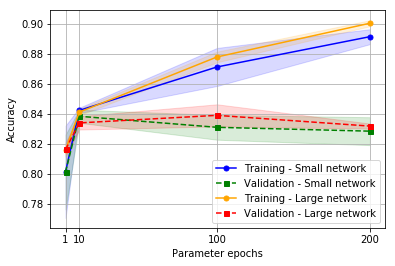

In [41]:
plot_validation_curves(
    small_network['mean_train_score'], small_network['std_train_score'], small_network['mean_test_score'], small_network['std_test_score'],
    large_network['mean_train_score'], large_network['std_train_score'], large_network['mean_test_score'], large_network['std_test_score'], 
    'epochs', param_grid['epochs'], ylim=None
)

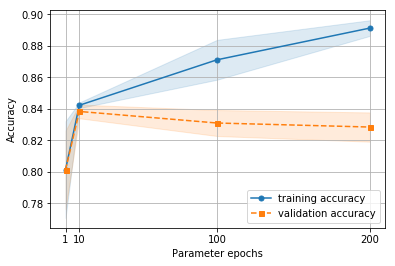

In [42]:
plot_validation_curve(small_network['mean_train_score'], small_network['std_train_score'], small_network['mean_test_score'], small_network['std_test_score'], 'epochs', param_grid['epochs'], ylim=None)

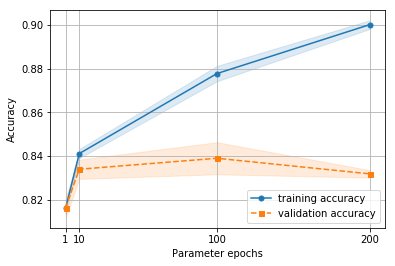

In [43]:
plot_validation_curve(large_network['mean_train_score'], large_network['std_train_score'], large_network['mean_test_score'], large_network['std_test_score'], 'epochs', param_grid['epochs'], ylim=None)

In [33]:
import scipy.stats

In [34]:
scipy.stats.describe(res['mean_fit_time'])

DescribeResult(nobs=8, minmax=(0.74851500988006592, 131.60571682453156), mean=45.339507736265659, variance=2619.6524230835089, skewness=0.6132955105105374, kurtosis=-1.1158091523381677)

In [35]:
scipy.stats.describe(res['mean_score_time'])

DescribeResult(nobs=8, minmax=(0.066115379333496094, 0.2704920768737793), mean=0.17069093137979507, variance=0.0053828156632827551, skewness=-0.0030788746193078065, kurtosis=-1.3226531034828621)

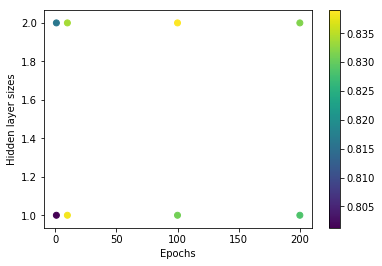

In [36]:
y = np.asarray([1,2,1,2,1,2,1,2])
yticks = ['(10,10)', '(100,100)']
x = np.asarray([1,1,10,10,100,100,200,200])

plt.scatter(x, y, c=res['mean_test_score'])
plt.xlabel('Epochs')
plt.ylabel('Hidden layer sizes')
plt.colorbar()
plt.show()

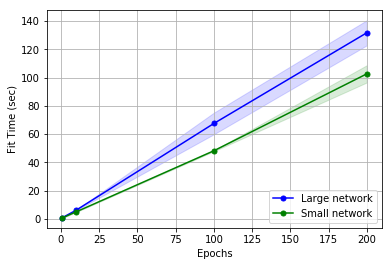

In [37]:
fig, ax = plt.subplots()

ax.plot(param_grid['epochs'], large_network['mean_fit_time'],
      color='blue', marker='o',
      markersize=5, label='Large network')
ax.fill_between(param_grid['epochs'],
              large_network['mean_fit_time'] + large_network['std_fit_time'],
              large_network['mean_fit_time'] - large_network['std_fit_time'],
              alpha=0.15, color='blue')

ax.plot(param_grid['epochs'], small_network['mean_fit_time'],
      color='green', marker='o',
      markersize=5, label='Small network')
ax.fill_between(param_grid['epochs'],
              small_network['mean_fit_time'] + small_network['std_fit_time'],
              small_network['mean_fit_time'] - small_network['std_fit_time'],
              alpha=0.15, color='green')

plt.grid()
plt.legend(loc='lower right')
ax.set_ylabel('Fit Time (sec)')
plt.xlabel('Epochs')
plt.show()

In [38]:
sorted(res['mean_fit_time'])

[0.74851500988006592,
 0.90811836719512939,
 5.0117236971855164,
 6.1952463984489441,
 48.186867356300354,
 67.482402384281158,
 102.57747185230255,
 131.60571682453156]

In [39]:
# The large network takes about 2.5-3 more minutes to train. I'll still choose it as the best learner

## Learning Curves for best learner

Epoch 1/100
1583/1583 [==============================] - 2s 1ms/step - loss: 0.2093 - acc: 0.7340
Epoch 2/100
1583/1583 [==============================] - 0s 58us/step - loss: 0.1800 - acc: 0.7536
Epoch 3/100
1583/1583 [==============================] - 0s 61us/step - loss: 0.1709 - acc: 0.7536
Epoch 4/100
1583/1583 [==============================] - 0s 60us/step - loss: 0.1627 - acc: 0.7536
Epoch 5/100
1583/1583 [==============================] - 0s 71us/step - loss: 0.1552 - acc: 0.7568
Epoch 6/100
1583/1583 [==============================] - 0s 60us/step - loss: 0.1491 - acc: 0.7764
Epoch 7/100
1583/1583 [==============================] - 0s 63us/step - loss: 0.1448 - acc: 0.7890
Epoch 8/100
1583/1583 [==============================] - 0s 56us/step - loss: 0.1410 - acc: 0.7953
Epoch 9/100
1583/1583 [==============================] - 0s 56us/step - loss: 0.1382 - acc: 0.8067
Epoch 10/100
1583/1583 [==============================] - 0s 56us/step - loss: 0.1354 - acc: 0.8105
Epoch 11/1

1583/1583 [==============================] - 0s 57us/step - loss: 0.0885 - acc: 0.8819
Epoch 84/100
1583/1583 [==============================] - 0s 57us/step - loss: 0.0865 - acc: 0.8869
Epoch 85/100
1583/1583 [==============================] - 0s 56us/step - loss: 0.0868 - acc: 0.8812
Epoch 86/100
1583/1583 [==============================] - 0s 58us/step - loss: 0.0867 - acc: 0.8806
Epoch 87/100
1583/1583 [==============================] - 0s 57us/step - loss: 0.0854 - acc: 0.8850
Epoch 88/100
1583/1583 [==============================] - 0s 54us/step - loss: 0.0868 - acc: 0.8774
Epoch 89/100
1583/1583 [==============================] - 0s 54us/step - loss: 0.0850 - acc: 0.8838
Epoch 90/100
1583/1583 [==============================] - 0s 54us/step - loss: 0.0837 - acc: 0.8863
Epoch 91/100
1583/1583 [==============================] - 0s 55us/step - loss: 0.0848 - acc: 0.8857
Epoch 92/100
1583/1583 [==============================] - 0s 54us/step - loss: 0.0823 - acc: 0.8825
Epoch 93/100


Epoch 64/100
3166/3166 [==============================] - 0s 54us/step - loss: 0.0934 - acc: 0.8696
Epoch 65/100
3166/3166 [==============================] - 0s 55us/step - loss: 0.0929 - acc: 0.8705
Epoch 66/100
3166/3166 [==============================] - 0s 59us/step - loss: 0.0916 - acc: 0.8708
Epoch 67/100
3166/3166 [==============================] - 0s 59us/step - loss: 0.0916 - acc: 0.8699
Epoch 68/100
3166/3166 [==============================] - 0s 60us/step - loss: 0.0913 - acc: 0.8683
Epoch 69/100
3166/3166 [==============================] - 0s 59us/step - loss: 0.0909 - acc: 0.8696
Epoch 70/100
3166/3166 [==============================] - 0s 57us/step - loss: 0.0901 - acc: 0.8749
Epoch 71/100
3166/3166 [==============================] - 0s 54us/step - loss: 0.0911 - acc: 0.8711
Epoch 72/100
3166/3166 [==============================] - 0s 57us/step - loss: 0.0921 - acc: 0.8661
Epoch 73/100
3166/3166 [==============================] - 0s 56us/step - loss: 0.0895 - acc: 0.8749


4750/4750 [==============================] - 0s 54us/step - loss: 0.1036 - acc: 0.8514
Epoch 45/100
4750/4750 [==============================] - 0s 53us/step - loss: 0.1036 - acc: 0.8497
Epoch 46/100
4750/4750 [==============================] - 0s 53us/step - loss: 0.1035 - acc: 0.8518
Epoch 47/100
4750/4750 [==============================] - 0s 53us/step - loss: 0.1026 - acc: 0.8535
Epoch 48/100
4750/4750 [==============================] - 0s 54us/step - loss: 0.1026 - acc: 0.8501
Epoch 49/100
4750/4750 [==============================] - 0s 54us/step - loss: 0.1005 - acc: 0.8575
Epoch 50/100
4750/4750 [==============================] - 0s 53us/step - loss: 0.1012 - acc: 0.8537
Epoch 51/100
4750/4750 [==============================] - 0s 54us/step - loss: 0.1015 - acc: 0.8549
Epoch 52/100
4750/4750 [==============================] - 0s 53us/step - loss: 0.1009 - acc: 0.8547
Epoch 53/100
4750/4750 [==============================] - 0s 53us/step - loss: 0.1006 - acc: 0.8585
Epoch 54/100


6333/6333 [==============================] - 0s 53us/step - loss: 0.1072 - acc: 0.8438
Epoch 25/100
6333/6333 [==============================] - 0s 52us/step - loss: 0.1065 - acc: 0.8481
Epoch 26/100
6333/6333 [==============================] - 0s 53us/step - loss: 0.1065 - acc: 0.8424
Epoch 27/100
6333/6333 [==============================] - 0s 53us/step - loss: 0.1057 - acc: 0.8456
Epoch 28/100
6333/6333 [==============================] - 0s 53us/step - loss: 0.1059 - acc: 0.8467
Epoch 29/100
6333/6333 [==============================] - 0s 52us/step - loss: 0.1055 - acc: 0.8492
Epoch 30/100
6333/6333 [==============================] - 0s 53us/step - loss: 0.1053 - acc: 0.8506
Epoch 31/100
6333/6333 [==============================] - 0s 52us/step - loss: 0.1051 - acc: 0.8479
Epoch 32/100
6333/6333 [==============================] - 0s 53us/step - loss: 0.1048 - acc: 0.8509
Epoch 33/100
6333/6333 [==============================] - 0s 53us/step - loss: 0.1041 - acc: 0.8467
Epoch 34/100


7917/7917 [==============================] - 0s 55us/step - loss: 0.1211 - acc: 0.8297
Epoch 5/100
7917/7917 [==============================] - 0s 53us/step - loss: 0.1186 - acc: 0.8305
Epoch 6/100
7917/7917 [==============================] - 0s 53us/step - loss: 0.1173 - acc: 0.8314
Epoch 7/100
7917/7917 [==============================] - 0s 54us/step - loss: 0.1161 - acc: 0.8335
Epoch 8/100
7917/7917 [==============================] - 0s 53us/step - loss: 0.1147 - acc: 0.8340
Epoch 9/100
7917/7917 [==============================] - 0s 53us/step - loss: 0.1141 - acc: 0.8353
Epoch 10/100
7917/7917 [==============================] - 0s 53us/step - loss: 0.1133 - acc: 0.8367
Epoch 11/100
7917/7917 [==============================] - 0s 55us/step - loss: 0.1119 - acc: 0.8395
Epoch 12/100
7917/7917 [==============================] - 0s 52us/step - loss: 0.1117 - acc: 0.8392
Epoch 13/100
7917/7917 [==============================] - 0s 53us/step - loss: 0.1111 - acc: 0.8384
Epoch 14/100
7917/

7917/7917 [==============================] - 0s 53us/step - loss: 0.0885 - acc: 0.8733
Epoch 86/100
7917/7917 [==============================] - 0s 53us/step - loss: 0.0876 - acc: 0.8785
Epoch 87/100
7917/7917 [==============================] - 0s 53us/step - loss: 0.0882 - acc: 0.8782
Epoch 88/100
7917/7917 [==============================] - 0s 53us/step - loss: 0.0882 - acc: 0.8761
Epoch 89/100
7917/7917 [==============================] - 0s 53us/step - loss: 0.0867 - acc: 0.8803
Epoch 90/100
7917/7917 [==============================] - 0s 53us/step - loss: 0.0890 - acc: 0.8765
Epoch 91/100
7917/7917 [==============================] - 0s 53us/step - loss: 0.0875 - acc: 0.8761
Epoch 92/100
7917/7917 [==============================] - 0s 53us/step - loss: 0.0872 - acc: 0.8771
Epoch 93/100
7917/7917 [==============================] - 0s 53us/step - loss: 0.0878 - acc: 0.8744
Epoch 94/100
7917/7917 [==============================] - 0s 54us/step - loss: 0.0865 - acc: 0.8779
Epoch 95/100


Epoch 66/100
9500/9500 [==============================] - 1s 53us/step - loss: 0.0944 - acc: 0.8652
Epoch 67/100
9500/9500 [==============================] - 1s 57us/step - loss: 0.0940 - acc: 0.8685
Epoch 68/100
9500/9500 [==============================] - 1s 54us/step - loss: 0.0950 - acc: 0.8663
Epoch 69/100
9500/9500 [==============================] - 1s 56us/step - loss: 0.0938 - acc: 0.8671
Epoch 70/100
9500/9500 [==============================] - 1s 54us/step - loss: 0.0934 - acc: 0.8671
Epoch 71/100
9500/9500 [==============================] - 1s 58us/step - loss: 0.0936 - acc: 0.8665
Epoch 72/100
9500/9500 [==============================] - 1s 58us/step - loss: 0.0933 - acc: 0.8669
Epoch 73/100
9500/9500 [==============================] - 1s 59us/step - loss: 0.0929 - acc: 0.8723
Epoch 74/100
9500/9500 [==============================] - 1s 59us/step - loss: 0.0925 - acc: 0.8684
Epoch 75/100
9500/9500 [==============================] - 1s 59us/step - loss: 0.0926 - acc: 0.8687


11083/11083 [==============================] - 1s 53us/step - loss: 0.0992 - acc: 0.8575
Epoch 46/100
11083/11083 [==============================] - 1s 52us/step - loss: 0.0992 - acc: 0.8584
Epoch 47/100
11083/11083 [==============================] - 1s 53us/step - loss: 0.0988 - acc: 0.8607
Epoch 48/100
11083/11083 [==============================] - 1s 53us/step - loss: 0.0973 - acc: 0.8621
Epoch 49/100
11083/11083 [==============================] - 1s 53us/step - loss: 0.0982 - acc: 0.8582
Epoch 50/100
11083/11083 [==============================] - 1s 53us/step - loss: 0.0973 - acc: 0.8626
Epoch 51/100
11083/11083 [==============================] - 1s 53us/step - loss: 0.0975 - acc: 0.8617
Epoch 52/100
11083/11083 [==============================] - 1s 53us/step - loss: 0.0970 - acc: 0.8629
Epoch 53/100
11083/11083 [==============================] - 1s 54us/step - loss: 0.0968 - acc: 0.8646
Epoch 54/100
11083/11083 [==============================] - 1s 53us/step - loss: 0.0961 - acc: 

12667/12667 [==============================] - 1s 53us/step - loss: 0.1053 - acc: 0.8469
Epoch 25/100
12667/12667 [==============================] - 1s 53us/step - loss: 0.1044 - acc: 0.8514
Epoch 26/100
12667/12667 [==============================] - 1s 53us/step - loss: 0.1038 - acc: 0.8506
Epoch 27/100
12667/12667 [==============================] - 1s 52us/step - loss: 0.1042 - acc: 0.8502
Epoch 28/100
12667/12667 [==============================] - 1s 52us/step - loss: 0.1032 - acc: 0.8533
Epoch 29/100
12667/12667 [==============================] - 1s 53us/step - loss: 0.1031 - acc: 0.8498
Epoch 30/100
12667/12667 [==============================] - 1s 54us/step - loss: 0.1026 - acc: 0.8523
Epoch 31/100
12667/12667 [==============================] - 1s 52us/step - loss: 0.1026 - acc: 0.8527
Epoch 32/100
12667/12667 [==============================] - 1s 50us/step - loss: 0.1023 - acc: 0.8534
Epoch 33/100
12667/12667 [==============================] - 1s 51us/step - loss: 0.1020 - acc: 

Epoch 3/100
14250/14250 [==============================] - 1s 55us/step - loss: 0.1198 - acc: 0.8278
Epoch 4/100
14250/14250 [==============================] - 1s 53us/step - loss: 0.1170 - acc: 0.8307
Epoch 5/100
14250/14250 [==============================] - 1s 55us/step - loss: 0.1149 - acc: 0.8324
Epoch 6/100
14250/14250 [==============================] - 1s 53us/step - loss: 0.1137 - acc: 0.8354
Epoch 7/100
14250/14250 [==============================] - 1s 54us/step - loss: 0.1125 - acc: 0.8357
Epoch 8/100
14250/14250 [==============================] - 1s 54us/step - loss: 0.1114 - acc: 0.8398
Epoch 9/100
14250/14250 [==============================] - 1s 53us/step - loss: 0.1111 - acc: 0.8391
Epoch 10/100
14250/14250 [==============================] - 1s 54us/step - loss: 0.1102 - acc: 0.8415
Epoch 11/100
14250/14250 [==============================] - 1s 53us/step - loss: 0.1096 - acc: 0.8420
Epoch 12/100
14250/14250 [==============================] - 1s 54us/step - loss: 0.1091 -

14250/14250 [==============================] - 1s 54us/step - loss: 0.0892 - acc: 0.8746
Epoch 84/100
14250/14250 [==============================] - 1s 53us/step - loss: 0.0890 - acc: 0.8746
Epoch 85/100
14250/14250 [==============================] - 1s 53us/step - loss: 0.0886 - acc: 0.8749
Epoch 86/100
14250/14250 [==============================] - 1s 53us/step - loss: 0.0892 - acc: 0.8755
Epoch 87/100
14250/14250 [==============================] - 1s 54us/step - loss: 0.0888 - acc: 0.8755
Epoch 88/100
14250/14250 [==============================] - 1s 53us/step - loss: 0.0884 - acc: 0.8754
Epoch 89/100
14250/14250 [==============================] - 1s 53us/step - loss: 0.0892 - acc: 0.8734
Epoch 90/100
14250/14250 [==============================] - 1s 53us/step - loss: 0.0887 - acc: 0.8752
Epoch 91/100
14250/14250 [==============================] - 1s 53us/step - loss: 0.0885 - acc: 0.8756
Epoch 92/100
14250/14250 [==============================] - 1s 53us/step - loss: 0.0872 - acc: 

15834/15834 [==============================] - 1s 53us/step - loss: 0.0942 - acc: 0.8636
Epoch 63/100
15834/15834 [==============================] - 1s 53us/step - loss: 0.0937 - acc: 0.8662
Epoch 64/100
15834/15834 [==============================] - 1s 53us/step - loss: 0.0934 - acc: 0.8655
Epoch 65/100
15834/15834 [==============================] - 1s 53us/step - loss: 0.0934 - acc: 0.8662
Epoch 66/100
15834/15834 [==============================] - 1s 54us/step - loss: 0.0928 - acc: 0.8672
Epoch 67/100
15834/15834 [==============================] - 1s 53us/step - loss: 0.0933 - acc: 0.8653
Epoch 68/100
15834/15834 [==============================] - 1s 53us/step - loss: 0.0927 - acc: 0.8696
Epoch 69/100
15834/15834 [==============================] - 1s 53us/step - loss: 0.0928 - acc: 0.8682
Epoch 70/100
15834/15834 [==============================] - 1s 53us/step - loss: 0.0924 - acc: 0.8678
Epoch 71/100
15834/15834 [==============================] - 1s 53us/step - loss: 0.0921 - acc: 

1583/1583 [==============================] - 0s 56us/step - loss: 0.1067 - acc: 0.8534
Epoch 43/100
1583/1583 [==============================] - 0s 59us/step - loss: 0.1061 - acc: 0.8478
Epoch 44/100
1583/1583 [==============================] - 0s 58us/step - loss: 0.1069 - acc: 0.8484
Epoch 45/100
1583/1583 [==============================] - 0s 57us/step - loss: 0.1059 - acc: 0.8471
Epoch 46/100
1583/1583 [==============================] - 0s 57us/step - loss: 0.1055 - acc: 0.8541
Epoch 47/100
1583/1583 [==============================] - 0s 57us/step - loss: 0.1048 - acc: 0.8515
Epoch 48/100
1583/1583 [==============================] - 0s 56us/step - loss: 0.1038 - acc: 0.8515
Epoch 49/100
1583/1583 [==============================] - 0s 58us/step - loss: 0.1044 - acc: 0.8541
Epoch 50/100
1583/1583 [==============================] - 0s 57us/step - loss: 0.1041 - acc: 0.8591
Epoch 51/100
1583/1583 [==============================] - 0s 58us/step - loss: 0.1028 - acc: 0.8503
Epoch 52/100


Epoch 23/100
3166/3166 [==============================] - 0s 56us/step - loss: 0.1109 - acc: 0.8411
Epoch 24/100
3166/3166 [==============================] - 0s 55us/step - loss: 0.1105 - acc: 0.8421
Epoch 25/100
3166/3166 [==============================] - 0s 55us/step - loss: 0.1095 - acc: 0.8405
Epoch 26/100
3166/3166 [==============================] - 0s 56us/step - loss: 0.1099 - acc: 0.8402
Epoch 27/100
3166/3166 [==============================] - 0s 55us/step - loss: 0.1094 - acc: 0.8408
Epoch 28/100
3166/3166 [==============================] - 0s 56us/step - loss: 0.1091 - acc: 0.8462
Epoch 29/100
3166/3166 [==============================] - 0s 56us/step - loss: 0.1089 - acc: 0.8440
Epoch 30/100
3166/3166 [==============================] - 0s 55us/step - loss: 0.1080 - acc: 0.8490
Epoch 31/100
3166/3166 [==============================] - 0s 56us/step - loss: 0.1077 - acc: 0.8474
Epoch 32/100
3166/3166 [==============================] - 0s 57us/step - loss: 0.1070 - acc: 0.8484


4750/4750 [==============================] - 0s 59us/step - loss: 0.1323 - acc: 0.8175
Epoch 4/100
4750/4750 [==============================] - 0s 62us/step - loss: 0.1268 - acc: 0.8255
Epoch 5/100
4750/4750 [==============================] - 0s 62us/step - loss: 0.1233 - acc: 0.8297
Epoch 6/100
4750/4750 [==============================] - 0s 63us/step - loss: 0.1212 - acc: 0.8318
Epoch 7/100
4750/4750 [==============================] - 0s 63us/step - loss: 0.1193 - acc: 0.8322
Epoch 8/100
4750/4750 [==============================] - 0s 63us/step - loss: 0.1182 - acc: 0.8316
Epoch 9/100
4750/4750 [==============================] - 0s 63us/step - loss: 0.1168 - acc: 0.8328
Epoch 10/100
4750/4750 [==============================] - 0s 66us/step - loss: 0.1157 - acc: 0.8354
Epoch 11/100
4750/4750 [==============================] - 0s 62us/step - loss: 0.1146 - acc: 0.8352
Epoch 12/100
4750/4750 [==============================] - 0s 64us/step - loss: 0.1142 - acc: 0.8335
Epoch 13/100
4750/4

4750/4750 [==============================] - 0s 60us/step - loss: 0.0865 - acc: 0.8787
Epoch 86/100
4750/4750 [==============================] - 0s 57us/step - loss: 0.0870 - acc: 0.8804
Epoch 87/100
4750/4750 [==============================] - 0s 59us/step - loss: 0.0859 - acc: 0.8819
Epoch 88/100
4750/4750 [==============================] - 0s 57us/step - loss: 0.0852 - acc: 0.8817
Epoch 89/100
4750/4750 [==============================] - 0s 58us/step - loss: 0.0860 - acc: 0.8823
Epoch 90/100
4750/4750 [==============================] - 0s 58us/step - loss: 0.0848 - acc: 0.8829
Epoch 91/100
4750/4750 [==============================] - 0s 60us/step - loss: 0.0847 - acc: 0.8827
Epoch 92/100
4750/4750 [==============================] - 0s 59us/step - loss: 0.0838 - acc: 0.8836
Epoch 93/100
4750/4750 [==============================] - 0s 57us/step - loss: 0.0835 - acc: 0.8855
Epoch 94/100
4750/4750 [==============================] - 0s 59us/step - loss: 0.0822 - acc: 0.8842
Epoch 95/100


6333/6333 [==============================] - 0s 56us/step - loss: 0.0948 - acc: 0.8677
Epoch 65/100
6333/6333 [==============================] - 0s 55us/step - loss: 0.0951 - acc: 0.8670
Epoch 66/100
6333/6333 [==============================] - 0s 55us/step - loss: 0.0930 - acc: 0.8707
Epoch 67/100
6333/6333 [==============================] - 0s 55us/step - loss: 0.0937 - acc: 0.8680
Epoch 68/100
6333/6333 [==============================] - 0s 55us/step - loss: 0.0927 - acc: 0.8707
Epoch 69/100
6333/6333 [==============================] - 0s 55us/step - loss: 0.0932 - acc: 0.8666
Epoch 70/100
6333/6333 [==============================] - 0s 55us/step - loss: 0.0921 - acc: 0.8700
Epoch 71/100
6333/6333 [==============================] - 0s 56us/step - loss: 0.0925 - acc: 0.8726
Epoch 72/100
6333/6333 [==============================] - 0s 55us/step - loss: 0.0931 - acc: 0.8726
Epoch 73/100
6333/6333 [==============================] - 0s 55us/step - loss: 0.0925 - acc: 0.8718
Epoch 74/100


7917/7917 [==============================] - 0s 56us/step - loss: 0.1011 - acc: 0.8523
Epoch 45/100
7917/7917 [==============================] - 0s 55us/step - loss: 0.0999 - acc: 0.8551
Epoch 46/100
7917/7917 [==============================] - 0s 55us/step - loss: 0.1010 - acc: 0.8535
Epoch 47/100
7917/7917 [==============================] - 0s 55us/step - loss: 0.0999 - acc: 0.8559
Epoch 48/100
7917/7917 [==============================] - 0s 56us/step - loss: 0.0994 - acc: 0.8587
Epoch 49/100
7917/7917 [==============================] - 0s 56us/step - loss: 0.0992 - acc: 0.8583
Epoch 50/100
7917/7917 [==============================] - 0s 56us/step - loss: 0.0989 - acc: 0.8585
Epoch 51/100
7917/7917 [==============================] - 0s 55us/step - loss: 0.0989 - acc: 0.8570
Epoch 52/100
7917/7917 [==============================] - 0s 55us/step - loss: 0.0987 - acc: 0.8600
Epoch 53/100
7917/7917 [==============================] - 0s 55us/step - loss: 0.0979 - acc: 0.8614
Epoch 54/100


Epoch 25/100
9500/9500 [==============================] - 1s 55us/step - loss: 0.1059 - acc: 0.8448
Epoch 26/100
9500/9500 [==============================] - 1s 55us/step - loss: 0.1056 - acc: 0.8463
Epoch 27/100
9500/9500 [==============================] - 1s 55us/step - loss: 0.1049 - acc: 0.8479
Epoch 28/100
9500/9500 [==============================] - 1s 55us/step - loss: 0.1045 - acc: 0.8486
Epoch 29/100
9500/9500 [==============================] - 1s 55us/step - loss: 0.1046 - acc: 0.8479
Epoch 30/100
9500/9500 [==============================] - 1s 55us/step - loss: 0.1041 - acc: 0.8513
Epoch 31/100
9500/9500 [==============================] - 1s 55us/step - loss: 0.1037 - acc: 0.8494
Epoch 32/100
9500/9500 [==============================] - 1s 55us/step - loss: 0.1034 - acc: 0.8493
Epoch 33/100
9500/9500 [==============================] - 1s 55us/step - loss: 0.1033 - acc: 0.8507
Epoch 34/100
9500/9500 [==============================] - 1s 55us/step - loss: 0.1028 - acc: 0.8520


11083/11083 [==============================] - 1s 55us/step - loss: 0.1161 - acc: 0.8343
Epoch 6/100
11083/11083 [==============================] - 1s 54us/step - loss: 0.1148 - acc: 0.8337
Epoch 7/100
11083/11083 [==============================] - 1s 55us/step - loss: 0.1141 - acc: 0.8352
Epoch 8/100
11083/11083 [==============================] - 1s 55us/step - loss: 0.1125 - acc: 0.8407
Epoch 9/100
11083/11083 [==============================] - ETA: 0s - loss: 0.1120 - acc: 0.840 - 1s 54us/step - loss: 0.1121 - acc: 0.8401
Epoch 10/100
11083/11083 [==============================] - 1s 58us/step - loss: 0.1115 - acc: 0.8403
Epoch 11/100
11083/11083 [==============================] - 1s 55us/step - loss: 0.1104 - acc: 0.8395
Epoch 12/100
11083/11083 [==============================] - 1s 55us/step - loss: 0.1102 - acc: 0.8427
Epoch 13/100
11083/11083 [==============================] - 1s 55us/step - loss: 0.1096 - acc: 0.8427
Epoch 14/100
11083/11083 [==============================] - 1

11083/11083 [==============================] - 1s 56us/step - loss: 0.0860 - acc: 0.8776
Epoch 85/100
11083/11083 [==============================] - 1s 55us/step - loss: 0.0864 - acc: 0.8790
Epoch 86/100
11083/11083 [==============================] - 1s 55us/step - loss: 0.0861 - acc: 0.8803
Epoch 87/100
11083/11083 [==============================] - 1s 55us/step - loss: 0.0868 - acc: 0.8795
Epoch 88/100
11083/11083 [==============================] - 1s 55us/step - loss: 0.0864 - acc: 0.8794
Epoch 89/100
11083/11083 [==============================] - 1s 55us/step - loss: 0.0853 - acc: 0.8815
Epoch 90/100
11083/11083 [==============================] - 1s 55us/step - loss: 0.0850 - acc: 0.8814
Epoch 91/100
11083/11083 [==============================] - 1s 55us/step - loss: 0.0865 - acc: 0.8772
Epoch 92/100
11083/11083 [==============================] - 1s 55us/step - loss: 0.0845 - acc: 0.8836
Epoch 93/100
11083/11083 [==============================] - 1s 55us/step - loss: 0.0852 - acc: 

12667/12667 [==============================] - 1s 55us/step - loss: 0.0934 - acc: 0.8677
Epoch 64/100
12667/12667 [==============================] - 1s 55us/step - loss: 0.0930 - acc: 0.8684
Epoch 65/100
12667/12667 [==============================] - 1s 55us/step - loss: 0.0928 - acc: 0.8694
Epoch 66/100
12667/12667 [==============================] - 1s 55us/step - loss: 0.0920 - acc: 0.8715
Epoch 67/100
12667/12667 [==============================] - 1s 54us/step - loss: 0.0915 - acc: 0.8738
Epoch 68/100
12667/12667 [==============================] - 1s 55us/step - loss: 0.0915 - acc: 0.8720
Epoch 69/100
12667/12667 [==============================] - 1s 55us/step - loss: 0.0916 - acc: 0.8716
Epoch 70/100
12667/12667 [==============================] - 1s 55us/step - loss: 0.0911 - acc: 0.8723
Epoch 71/100
12667/12667 [==============================] - 1s 55us/step - loss: 0.0911 - acc: 0.8713
Epoch 72/100
12667/12667 [==============================] - 1s 55us/step - loss: 0.0908 - acc: 

14250/14250 [==============================] - 1s 56us/step - loss: 0.0981 - acc: 0.8616
Epoch 43/100
14250/14250 [==============================] - 1s 56us/step - loss: 0.0985 - acc: 0.8600
Epoch 44/100
14250/14250 [==============================] - 1s 55us/step - loss: 0.0979 - acc: 0.8619
Epoch 45/100
14250/14250 [==============================] - 1s 56us/step - loss: 0.0977 - acc: 0.8618
Epoch 46/100
14250/14250 [==============================] - 1s 55us/step - loss: 0.0972 - acc: 0.8627
Epoch 47/100
14250/14250 [==============================] - 1s 55us/step - loss: 0.0967 - acc: 0.8643
Epoch 48/100
14250/14250 [==============================] - 1s 56us/step - loss: 0.0967 - acc: 0.8634
Epoch 49/100
14250/14250 [==============================] - 1s 55us/step - loss: 0.0970 - acc: 0.8637
Epoch 50/100
14250/14250 [==============================] - 1s 55us/step - loss: 0.0960 - acc: 0.8664
Epoch 51/100
14250/14250 [==============================] - 1s 55us/step - loss: 0.0962 - acc: 

15834/15834 [==============================] - 1s 56us/step - loss: 0.1064 - acc: 0.8451
Epoch 22/100
15834/15834 [==============================] - 1s 56us/step - loss: 0.1056 - acc: 0.8472
Epoch 23/100
15834/15834 [==============================] - 1s 56us/step - loss: 0.1054 - acc: 0.8470
Epoch 24/100
15834/15834 [==============================] - 1s 56us/step - loss: 0.1052 - acc: 0.8487
Epoch 25/100
15834/15834 [==============================] - 1s 56us/step - loss: 0.1049 - acc: 0.8504
Epoch 26/100
15834/15834 [==============================] - 1s 56us/step - loss: 0.1044 - acc: 0.8481
Epoch 27/100
15834/15834 [==============================] - 1s 56us/step - loss: 0.1041 - acc: 0.8494
Epoch 28/100
15834/15834 [==============================] - 1s 56us/step - loss: 0.1039 - acc: 0.8507
Epoch 29/100
15834/15834 [==============================] - 1s 56us/step - loss: 0.1031 - acc: 0.8537
Epoch 30/100
15834/15834 [==============================] - 1s 56us/step - loss: 0.1033 - acc: 

15834/15834 [==============================] - 1s 33us/step
Epoch 1/100
1583/1583 [==============================] - 2s 1ms/step - loss: 0.1988 - acc: 0.7296
Epoch 2/100
1583/1583 [==============================] - 0s 60us/step - loss: 0.1779 - acc: 0.7296
Epoch 3/100
1583/1583 [==============================] - 0s 59us/step - loss: 0.1659 - acc: 0.7296
Epoch 4/100
1583/1583 [==============================] - 0s 61us/step - loss: 0.1556 - acc: 0.7562
Epoch 5/100
1583/1583 [==============================] - 0s 60us/step - loss: 0.1479 - acc: 0.7934
Epoch 6/100
1583/1583 [==============================] - 0s 61us/step - loss: 0.1426 - acc: 0.8067
Epoch 7/100
1583/1583 [==============================] - 0s 62us/step - loss: 0.1379 - acc: 0.8111
Epoch 8/100
1583/1583 [==============================] - 0s 62us/step - loss: 0.1343 - acc: 0.8149
Epoch 9/100
1583/1583 [==============================] - 0s 64us/step - loss: 0.1319 - acc: 0.8117
Epoch 10/100
1583/1583 [==========================

1583/1583 [==============================] - 0s 62us/step - loss: 0.0908 - acc: 0.8838
Epoch 81/100
1583/1583 [==============================] - 0s 61us/step - loss: 0.0912 - acc: 0.8793
Epoch 82/100
1583/1583 [==============================] - 0s 60us/step - loss: 0.0907 - acc: 0.8800
Epoch 83/100
1583/1583 [==============================] - 0s 62us/step - loss: 0.0910 - acc: 0.8812
Epoch 84/100
1583/1583 [==============================] - 0s 62us/step - loss: 0.0904 - acc: 0.8825
Epoch 85/100
1583/1583 [==============================] - 0s 63us/step - loss: 0.0891 - acc: 0.8825
Epoch 86/100
1583/1583 [==============================] - 0s 59us/step - loss: 0.0887 - acc: 0.8869
Epoch 87/100
1583/1583 [==============================] - 0s 60us/step - loss: 0.0883 - acc: 0.8876
Epoch 88/100
1583/1583 [==============================] - 0s 62us/step - loss: 0.0883 - acc: 0.8850
Epoch 89/100
1583/1583 [==============================] - 0s 62us/step - loss: 0.0875 - acc: 0.8857
Epoch 90/100


3166/3166 [==============================] - 0s 59us/step - loss: 0.0968 - acc: 0.8680
Epoch 61/100
3166/3166 [==============================] - 0s 58us/step - loss: 0.0961 - acc: 0.8711
Epoch 62/100
3166/3166 [==============================] - 0s 58us/step - loss: 0.0958 - acc: 0.8673
Epoch 63/100
3166/3166 [==============================] - 0s 59us/step - loss: 0.0953 - acc: 0.8702
Epoch 64/100
3166/3166 [==============================] - 0s 58us/step - loss: 0.0945 - acc: 0.8743
Epoch 65/100
3166/3166 [==============================] - 0s 58us/step - loss: 0.0956 - acc: 0.8680
Epoch 66/100
3166/3166 [==============================] - 0s 58us/step - loss: 0.0948 - acc: 0.8677
Epoch 67/100
3166/3166 [==============================] - 0s 58us/step - loss: 0.0934 - acc: 0.8727
Epoch 68/100
3166/3166 [==============================] - 0s 58us/step - loss: 0.0929 - acc: 0.8746
Epoch 69/100
3166/3166 [==============================] - 0s 58us/step - loss: 0.0931 - acc: 0.8740
Epoch 70/100


Epoch 41/100
4750/4750 [==============================] - 0s 58us/step - loss: 0.1017 - acc: 0.8535
Epoch 42/100
4750/4750 [==============================] - 0s 58us/step - loss: 0.1019 - acc: 0.8526
Epoch 43/100
4750/4750 [==============================] - 0s 57us/step - loss: 0.1013 - acc: 0.8522
Epoch 44/100
4750/4750 [==============================] - 0s 57us/step - loss: 0.1012 - acc: 0.8558
Epoch 45/100
4750/4750 [==============================] - 0s 58us/step - loss: 0.1004 - acc: 0.8573
Epoch 46/100
4750/4750 [==============================] - 0s 57us/step - loss: 0.1008 - acc: 0.8577
Epoch 47/100
4750/4750 [==============================] - 0s 57us/step - loss: 0.0998 - acc: 0.8585
Epoch 48/100
4750/4750 [==============================] - 0s 58us/step - loss: 0.1000 - acc: 0.8583
Epoch 49/100
4750/4750 [==============================] - 0s 58us/step - loss: 0.0995 - acc: 0.8552
Epoch 50/100
4750/4750 [==============================] - 0s 58us/step - loss: 0.0998 - acc: 0.8604


6333/6333 [==============================] - 0s 58us/step - loss: 0.1104 - acc: 0.8410
Epoch 22/100
6333/6333 [==============================] - 0s 57us/step - loss: 0.1098 - acc: 0.8393
Epoch 23/100
6333/6333 [==============================] - 0s 57us/step - loss: 0.1093 - acc: 0.8421
Epoch 24/100
6333/6333 [==============================] - 0s 58us/step - loss: 0.1090 - acc: 0.8405
Epoch 25/100
6333/6333 [==============================] - 0s 59us/step - loss: 0.1086 - acc: 0.8443
Epoch 26/100
6333/6333 [==============================] - 0s 57us/step - loss: 0.1084 - acc: 0.8408
Epoch 27/100
6333/6333 [==============================] - 0s 57us/step - loss: 0.1088 - acc: 0.8446
Epoch 28/100
6333/6333 [==============================] - 0s 58us/step - loss: 0.1073 - acc: 0.8471
Epoch 29/100
6333/6333 [==============================] - 0s 57us/step - loss: 0.1075 - acc: 0.8467
Epoch 30/100
6333/6333 [==============================] - 0s 58us/step - loss: 0.1066 - acc: 0.8457
Epoch 31/100


7917/7917 [==============================] - 3s 319us/step - loss: 0.1675 - acc: 0.7566
Epoch 2/100
7917/7917 [==============================] - 0s 57us/step - loss: 0.1343 - acc: 0.8112
Epoch 3/100
7917/7917 [==============================] - 0s 58us/step - loss: 0.1259 - acc: 0.8200
Epoch 4/100
7917/7917 [==============================] - 0s 58us/step - loss: 0.1217 - acc: 0.8247
Epoch 5/100
7917/7917 [==============================] - 0s 58us/step - loss: 0.1193 - acc: 0.8276
Epoch 6/100
7917/7917 [==============================] - 0s 58us/step - loss: 0.1173 - acc: 0.8343
Epoch 7/100
7917/7917 [==============================] - 0s 58us/step - loss: 0.1158 - acc: 0.8323
Epoch 8/100
7917/7917 [==============================] - 0s 58us/step - loss: 0.1150 - acc: 0.8372
Epoch 9/100
7917/7917 [==============================] - 0s 58us/step - loss: 0.1138 - acc: 0.8372
Epoch 10/100
7917/7917 [==============================] - 0s 58us/step - loss: 0.1134 - acc: 0.8364
Epoch 11/100
7917/79

7917/7917 [==============================] - 0s 62us/step - loss: 0.0883 - acc: 0.8791
Epoch 84/100
7917/7917 [==============================] - 0s 60us/step - loss: 0.0878 - acc: 0.8790
Epoch 85/100
7917/7917 [==============================] - 0s 58us/step - loss: 0.0879 - acc: 0.8789
Epoch 86/100
7917/7917 [==============================] - 0s 57us/step - loss: 0.0865 - acc: 0.8791
Epoch 87/100
7917/7917 [==============================] - 0s 58us/step - loss: 0.0864 - acc: 0.8801
Epoch 88/100
7917/7917 [==============================] - 0s 58us/step - loss: 0.0862 - acc: 0.8777
Epoch 89/100
7917/7917 [==============================] - 0s 58us/step - loss: 0.0855 - acc: 0.8827
Epoch 90/100
7917/7917 [==============================] - 0s 58us/step - loss: 0.0859 - acc: 0.8787
Epoch 91/100
7917/7917 [==============================] - 0s 58us/step - loss: 0.0854 - acc: 0.8843
Epoch 92/100
7917/7917 [==============================] - 0s 58us/step - loss: 0.0858 - acc: 0.8784
Epoch 93/100


9500/9500 [==============================] - 1s 55us/step - loss: 0.0965 - acc: 0.8644
Epoch 64/100
9500/9500 [==============================] - 1s 55us/step - loss: 0.0959 - acc: 0.8623
Epoch 65/100
9500/9500 [==============================] - 1s 54us/step - loss: 0.0960 - acc: 0.8642
Epoch 66/100
9500/9500 [==============================] - 1s 54us/step - loss: 0.0951 - acc: 0.8661
Epoch 67/100
9500/9500 [==============================] - 1s 55us/step - loss: 0.0948 - acc: 0.8642
Epoch 68/100
9500/9500 [==============================] - 1s 54us/step - loss: 0.0948 - acc: 0.8647
Epoch 69/100
9500/9500 [==============================] - 1s 55us/step - loss: 0.0945 - acc: 0.8664
Epoch 70/100
9500/9500 [==============================] - 1s 54us/step - loss: 0.0950 - acc: 0.8636
Epoch 71/100
9500/9500 [==============================] - 1s 56us/step - loss: 0.0935 - acc: 0.8699
Epoch 72/100
9500/9500 [==============================] - 1s 54us/step - loss: 0.0935 - acc: 0.8700
Epoch 73/100


11083/11083 [==============================] - 1s 54us/step - loss: 0.1015 - acc: 0.8529
Epoch 44/100
11083/11083 [==============================] - 1s 54us/step - loss: 0.1009 - acc: 0.8544
Epoch 45/100
11083/11083 [==============================] - 1s 54us/step - loss: 0.1010 - acc: 0.8564
Epoch 46/100
11083/11083 [==============================] - 1s 54us/step - loss: 0.1010 - acc: 0.8550
Epoch 47/100
11083/11083 [==============================] - 1s 54us/step - loss: 0.1008 - acc: 0.8577
Epoch 48/100
11083/11083 [==============================] - 1s 54us/step - loss: 0.0996 - acc: 0.8585
Epoch 49/100
11083/11083 [==============================] - 1s 54us/step - loss: 0.0996 - acc: 0.8559
Epoch 50/100
11083/11083 [==============================] - 1s 54us/step - loss: 0.1002 - acc: 0.8569
Epoch 51/100
11083/11083 [==============================] - 1s 56us/step - loss: 0.0992 - acc: 0.8578
Epoch 52/100
11083/11083 [==============================] - 1s 55us/step - loss: 0.0991 - acc: 

12667/12667 [==============================] - 1s 55us/step - loss: 0.1062 - acc: 0.8461
Epoch 23/100
12667/12667 [==============================] - 1s 54us/step - loss: 0.1062 - acc: 0.8477
Epoch 24/100
12667/12667 [==============================] - 1s 55us/step - loss: 0.1056 - acc: 0.8467
Epoch 25/100
12667/12667 [==============================] - 1s 55us/step - loss: 0.1055 - acc: 0.8483
Epoch 26/100
12667/12667 [==============================] - 1s 55us/step - loss: 0.1053 - acc: 0.8461
Epoch 27/100
12667/12667 [==============================] - 1s 54us/step - loss: 0.1046 - acc: 0.8480
Epoch 28/100
12667/12667 [==============================] - 1s 54us/step - loss: 0.1039 - acc: 0.8494
Epoch 29/100
12667/12667 [==============================] - 1s 54us/step - loss: 0.1036 - acc: 0.8504
Epoch 30/100
12667/12667 [==============================] - 1s 55us/step - loss: 0.1033 - acc: 0.8495
Epoch 31/100
12667/12667 [==============================] - 1s 55us/step - loss: 0.1033 - acc: 

14250/14250 [==============================] - 3s 205us/step - loss: 0.1604 - acc: 0.7683
Epoch 2/100
14250/14250 [==============================] - 1s 58us/step - loss: 0.1292 - acc: 0.8190
Epoch 3/100
14250/14250 [==============================] - 1s 58us/step - loss: 0.1208 - acc: 0.8272
Epoch 4/100
14250/14250 [==============================] - 1s 57us/step - loss: 0.1171 - acc: 0.8312
Epoch 5/100
14250/14250 [==============================] - 1s 58us/step - loss: 0.1153 - acc: 0.8319
Epoch 6/100
14250/14250 [==============================] - 1s 58us/step - loss: 0.1137 - acc: 0.8347
Epoch 7/100
14250/14250 [==============================] - 1s 58us/step - loss: 0.1128 - acc: 0.8368
Epoch 8/100
14250/14250 [==============================] - 1s 56us/step - loss: 0.1118 - acc: 0.8380
Epoch 9/100
14250/14250 [==============================] - 1s 55us/step - loss: 0.1112 - acc: 0.8384
Epoch 10/100
14250/14250 [==============================] - 1s 55us/step - loss: 0.1106 - acc: 0.8391


14250/14250 [==============================] - 1s 58us/step - loss: 0.0918 - acc: 0.8705
Epoch 82/100
14250/14250 [==============================] - 1s 58us/step - loss: 0.0909 - acc: 0.8742
Epoch 83/100
14250/14250 [==============================] - 1s 58us/step - loss: 0.0914 - acc: 0.8700
Epoch 84/100
14250/14250 [==============================] - 1s 58us/step - loss: 0.0914 - acc: 0.8700
Epoch 85/100
14250/14250 [==============================] - 1s 58us/step - loss: 0.0907 - acc: 0.8722
Epoch 86/100
14250/14250 [==============================] - 1s 58us/step - loss: 0.0907 - acc: 0.8697
Epoch 87/100
14250/14250 [==============================] - 1s 58us/step - loss: 0.0903 - acc: 0.8704
Epoch 88/100
14250/14250 [==============================] - 1s 58us/step - loss: 0.0900 - acc: 0.8720
Epoch 89/100
14250/14250 [==============================] - 1s 59us/step - loss: 0.0903 - acc: 0.8738
Epoch 90/100
14250/14250 [==============================] - 1s 58us/step - loss: 0.0900 - acc: 

15834/15834 [==============================] - 7s 416us/step - loss: 0.0947 - acc: 0.8633
Epoch 60/100
15834/15834 [==============================] - 6s 384us/step - loss: 0.0952 - acc: 0.8642
Epoch 61/100
15834/15834 [==============================] - 4s 223us/step - loss: 0.0952 - acc: 0.8639
Epoch 62/100
15834/15834 [==============================] - 3s 181us/step - loss: 0.0945 - acc: 0.8647
Epoch 63/100
15834/15834 [==============================] - 3s 181us/step - loss: 0.0946 - acc: 0.8650
Epoch 64/100
15834/15834 [==============================] - 3s 162us/step - loss: 0.0939 - acc: 0.8660
Epoch 65/100
15834/15834 [==============================] - 2s 140us/step - loss: 0.0936 - acc: 0.8668
Epoch 66/100
15834/15834 [==============================] - 2s 133us/step - loss: 0.0934 - acc: 0.8680
Epoch 67/100
15834/15834 [==============================] - 2s 120us/step - loss: 0.0934 - acc: 0.8681
Epoch 68/100
15834/15834 [==============================] - 2s 111us/step - loss: 0.09

1583/1583 [==============================] - 0s 69us/step - loss: 0.1085 - acc: 0.8459
Epoch 40/100
1583/1583 [==============================] - 0s 66us/step - loss: 0.1087 - acc: 0.8459
Epoch 41/100
1583/1583 [==============================] - 0s 62us/step - loss: 0.1078 - acc: 0.8471
Epoch 42/100
1583/1583 [==============================] - 0s 60us/step - loss: 0.1075 - acc: 0.8452
Epoch 43/100
1583/1583 [==============================] - 0s 66us/step - loss: 0.1071 - acc: 0.8509
Epoch 44/100
1583/1583 [==============================] - 0s 63us/step - loss: 0.1059 - acc: 0.8452
Epoch 45/100
1583/1583 [==============================] - 0s 62us/step - loss: 0.1063 - acc: 0.8528
Epoch 46/100
1583/1583 [==============================] - 0s 64us/step - loss: 0.1061 - acc: 0.8484
Epoch 47/100
1583/1583 [==============================] - 0s 65us/step - loss: 0.1052 - acc: 0.8490
Epoch 48/100
1583/1583 [==============================] - 0s 63us/step - loss: 0.1050 - acc: 0.8497
Epoch 49/100


3166/3166 [==============================] - 0s 63us/step - loss: 0.1115 - acc: 0.8389
Epoch 20/100
3166/3166 [==============================] - 0s 64us/step - loss: 0.1112 - acc: 0.8418
Epoch 21/100
3166/3166 [==============================] - 0s 62us/step - loss: 0.1111 - acc: 0.8421
Epoch 22/100
3166/3166 [==============================] - 0s 63us/step - loss: 0.1102 - acc: 0.8389
Epoch 23/100
3166/3166 [==============================] - 0s 64us/step - loss: 0.1094 - acc: 0.8462
Epoch 24/100
3166/3166 [==============================] - 0s 65us/step - loss: 0.1088 - acc: 0.8446
Epoch 25/100
3166/3166 [==============================] - 0s 63us/step - loss: 0.1087 - acc: 0.8446
Epoch 26/100
3166/3166 [==============================] - 0s 63us/step - loss: 0.1084 - acc: 0.8462
Epoch 27/100
3166/3166 [==============================] - 0s 62us/step - loss: 0.1078 - acc: 0.8440
Epoch 28/100
3166/3166 [==============================] - 0s 63us/step - loss: 0.1070 - acc: 0.8503
Epoch 29/100


3166/3166 [==============================] - 0s 64us/step - loss: 0.0805 - acc: 0.8920
Epoch 100/100
3166/3166 [==============================] - 0s 41us/step
Epoch 1/100
4750/4750 [==============================] - 3s 554us/step - loss: 0.1833 - acc: 0.7488
Epoch 2/100
4750/4750 [==============================] - 0s 61us/step - loss: 0.1496 - acc: 0.7573
Epoch 3/100
4750/4750 [==============================] - 0s 62us/step - loss: 0.1370 - acc: 0.8139
Epoch 4/100
4750/4750 [==============================] - 0s 62us/step - loss: 0.1296 - acc: 0.8240
Epoch 5/100
4750/4750 [==============================] - 0s 63us/step - loss: 0.1247 - acc: 0.8272
Epoch 6/100
4750/4750 [==============================] - 0s 63us/step - loss: 0.1216 - acc: 0.8265
Epoch 7/100
4750/4750 [==============================] - 0s 62us/step - loss: 0.1194 - acc: 0.8284
Epoch 8/100
4750/4750 [==============================] - 0s 62us/step - loss: 0.1180 - acc: 0.8318
Epoch 9/100
4750/4750 [=========================

4750/4750 [==============================] - 0s 99us/step - loss: 0.0892 - acc: 0.8771
Epoch 80/100
4750/4750 [==============================] - 1s 119us/step - loss: 0.0880 - acc: 0.8787
Epoch 81/100
4750/4750 [==============================] - 0s 61us/step - loss: 0.0865 - acc: 0.8821
Epoch 82/100
4750/4750 [==============================] - 0s 60us/step - loss: 0.0873 - acc: 0.8804
Epoch 83/100
4750/4750 [==============================] - 0s 61us/step - loss: 0.0866 - acc: 0.8800
Epoch 84/100
4750/4750 [==============================] - 0s 64us/step - loss: 0.0865 - acc: 0.8806
Epoch 85/100
4750/4750 [==============================] - 0s 61us/step - loss: 0.0864 - acc: 0.8779
Epoch 86/100
4750/4750 [==============================] - 0s 60us/step - loss: 0.0856 - acc: 0.8823
Epoch 87/100
4750/4750 [==============================] - 0s 60us/step - loss: 0.0853 - acc: 0.8808
Epoch 88/100
4750/4750 [==============================] - 0s 62us/step - loss: 0.0848 - acc: 0.8802
Epoch 89/100

Epoch 60/100
6333/6333 [==============================] - 0s 59us/step - loss: 0.0988 - acc: 0.8596
Epoch 61/100
6333/6333 [==============================] - 0s 59us/step - loss: 0.0977 - acc: 0.8629
Epoch 62/100
6333/6333 [==============================] - 0s 59us/step - loss: 0.0978 - acc: 0.8629
Epoch 63/100
6333/6333 [==============================] - 0s 60us/step - loss: 0.0974 - acc: 0.8637
Epoch 64/100
6333/6333 [==============================] - 0s 59us/step - loss: 0.0973 - acc: 0.8637
Epoch 65/100
6333/6333 [==============================] - 0s 59us/step - loss: 0.0963 - acc: 0.8664
Epoch 66/100
6333/6333 [==============================] - 0s 59us/step - loss: 0.0965 - acc: 0.8674
Epoch 67/100
6333/6333 [==============================] - 0s 59us/step - loss: 0.0968 - acc: 0.8612
Epoch 68/100
6333/6333 [==============================] - 0s 59us/step - loss: 0.0960 - acc: 0.8658
Epoch 69/100
6333/6333 [==============================] - 0s 60us/step - loss: 0.0956 - acc: 0.8658


7917/7917 [==============================] - 1s 70us/step - loss: 0.1025 - acc: 0.8504
Epoch 41/100
7917/7917 [==============================] - 1s 69us/step - loss: 0.1016 - acc: 0.8534
Epoch 42/100
7917/7917 [==============================] - 1s 68us/step - loss: 0.1024 - acc: 0.8550
Epoch 43/100
7917/7917 [==============================] - 1s 68us/step - loss: 0.1018 - acc: 0.8532
Epoch 44/100
7917/7917 [==============================] - 1s 68us/step - loss: 0.1012 - acc: 0.8536
Epoch 45/100
7917/7917 [==============================] - 1s 68us/step - loss: 0.1008 - acc: 0.8558
Epoch 46/100
7917/7917 [==============================] - 1s 68us/step - loss: 0.1006 - acc: 0.8560
Epoch 47/100
7917/7917 [==============================] - 1s 68us/step - loss: 0.1005 - acc: 0.8531
Epoch 48/100
7917/7917 [==============================] - 1s 68us/step - loss: 0.1010 - acc: 0.8520
Epoch 49/100
7917/7917 [==============================] - 1s 67us/step - loss: 0.0995 - acc: 0.8573
Epoch 50/100


9500/9500 [==============================] - 1s 67us/step - loss: 0.1092 - acc: 0.8377
Epoch 21/100
9500/9500 [==============================] - 1s 70us/step - loss: 0.1084 - acc: 0.8437
Epoch 22/100
9500/9500 [==============================] - 1s 68us/step - loss: 0.1083 - acc: 0.8408
Epoch 23/100
9500/9500 [==============================] - 1s 68us/step - loss: 0.1076 - acc: 0.8460
Epoch 24/100
9500/9500 [==============================] - 1s 68us/step - loss: 0.1069 - acc: 0.8440
Epoch 25/100
9500/9500 [==============================] - 1s 67us/step - loss: 0.1068 - acc: 0.8457
Epoch 26/100
9500/9500 [==============================] - 1s 68us/step - loss: 0.1068 - acc: 0.8452
Epoch 27/100
9500/9500 [==============================] - 1s 67us/step - loss: 0.1064 - acc: 0.8455
Epoch 28/100
9500/9500 [==============================] - 1s 68us/step - loss: 0.1063 - acc: 0.8459
Epoch 29/100
9500/9500 [==============================] - 1s 68us/step - loss: 0.1055 - acc: 0.8482
Epoch 30/100


9500/9500 [==============================] - 0s 34us/step
Epoch 1/100
11083/11083 [==============================] - 4s 339us/step - loss: 0.1632 - acc: 0.7671
Epoch 2/100
11083/11083 [==============================] - 1s 63us/step - loss: 0.1283 - acc: 0.8174
Epoch 3/100
11083/11083 [==============================] - 1s 60us/step - loss: 0.1223 - acc: 0.8227
Epoch 4/100
11083/11083 [==============================] - 1s 60us/step - loss: 0.1191 - acc: 0.8291
Epoch 5/100
11083/11083 [==============================] - 1s 60us/step - loss: 0.1174 - acc: 0.8313
Epoch 6/100
11083/11083 [==============================] - 1s 60us/step - loss: 0.1156 - acc: 0.8337
Epoch 7/100
11083/11083 [==============================] - 1s 60us/step - loss: 0.1148 - acc: 0.8359
Epoch 8/100
11083/11083 [==============================] - 1s 60us/step - loss: 0.1138 - acc: 0.8343
Epoch 9/100
11083/11083 [==============================] - 1s 60us/step - loss: 0.1126 - acc: 0.8387
Epoch 10/100
11083/11083 [======

11083/11083 [==============================] - 1s 60us/step - loss: 0.0908 - acc: 0.8715
Epoch 81/100
11083/11083 [==============================] - 1s 60us/step - loss: 0.0908 - acc: 0.8733
Epoch 82/100
11083/11083 [==============================] - 1s 59us/step - loss: 0.0908 - acc: 0.8719
Epoch 83/100
11083/11083 [==============================] - 1s 60us/step - loss: 0.0892 - acc: 0.8756
Epoch 84/100
11083/11083 [==============================] - 1s 60us/step - loss: 0.0895 - acc: 0.8745
Epoch 85/100
11083/11083 [==============================] - 1s 60us/step - loss: 0.0901 - acc: 0.8746
Epoch 86/100
11083/11083 [==============================] - 1s 60us/step - loss: 0.0891 - acc: 0.8748
Epoch 87/100
11083/11083 [==============================] - 1s 60us/step - loss: 0.0891 - acc: 0.8762
Epoch 88/100
11083/11083 [==============================] - 1s 59us/step - loss: 0.0893 - acc: 0.8745
Epoch 89/100
11083/11083 [==============================] - 1s 60us/step - loss: 0.0892 - acc: 

Epoch 59/100
12667/12667 [==============================] - 1s 58us/step - loss: 0.0962 - acc: 0.8615
Epoch 60/100
12667/12667 [==============================] - 1s 58us/step - loss: 0.0956 - acc: 0.8614
Epoch 61/100
12667/12667 [==============================] - 1s 58us/step - loss: 0.0958 - acc: 0.8625
Epoch 62/100
12667/12667 [==============================] - 1s 58us/step - loss: 0.0954 - acc: 0.8624
Epoch 63/100
12667/12667 [==============================] - 1s 58us/step - loss: 0.0948 - acc: 0.8638
Epoch 64/100
12667/12667 [==============================] - 1s 58us/step - loss: 0.0949 - acc: 0.8639
Epoch 65/100
12667/12667 [==============================] - 1s 58us/step - loss: 0.0943 - acc: 0.8677
Epoch 66/100
12667/12667 [==============================] - 1s 64us/step - loss: 0.0940 - acc: 0.8663
Epoch 67/100
12667/12667 [==============================] - 1s 66us/step - loss: 0.0942 - acc: 0.8652
Epoch 68/100
12667/12667 [==============================] - 1s 66us/step - loss: 0

14250/14250 [==============================] - 1s 56us/step - loss: 0.1018 - acc: 0.8540
Epoch 39/100
14250/14250 [==============================] - 1s 56us/step - loss: 0.1016 - acc: 0.8540
Epoch 40/100
14250/14250 [==============================] - 1s 57us/step - loss: 0.1010 - acc: 0.8554
Epoch 41/100
14250/14250 [==============================] - 1s 57us/step - loss: 0.1007 - acc: 0.8571
Epoch 42/100
14250/14250 [==============================] - 1s 56us/step - loss: 0.1007 - acc: 0.8547
Epoch 43/100
14250/14250 [==============================] - 1s 57us/step - loss: 0.1005 - acc: 0.8553
Epoch 44/100
14250/14250 [==============================] - 1s 59us/step - loss: 0.1004 - acc: 0.8542
Epoch 45/100
14250/14250 [==============================] - 1s 59us/step - loss: 0.0999 - acc: 0.8566
Epoch 46/100
14250/14250 [==============================] - 1s 59us/step - loss: 0.0997 - acc: 0.8564
Epoch 47/100
14250/14250 [==============================] - 1s 59us/step - loss: 0.0993 - acc: 

15834/15834 [==============================] - 1s 59us/step - loss: 0.1093 - acc: 0.8425
Epoch 17/100
15834/15834 [==============================] - 1s 59us/step - loss: 0.1088 - acc: 0.8420
Epoch 18/100
15834/15834 [==============================] - 1s 61us/step - loss: 0.1086 - acc: 0.8431
Epoch 19/100
15834/15834 [==============================] - 1s 59us/step - loss: 0.1078 - acc: 0.8450
Epoch 20/100
15834/15834 [==============================] - 1s 59us/step - loss: 0.1073 - acc: 0.8436
Epoch 21/100
15834/15834 [==============================] - 1s 58us/step - loss: 0.1075 - acc: 0.8446
Epoch 22/100
15834/15834 [==============================] - 1s 59us/step - loss: 0.1067 - acc: 0.8467
Epoch 23/100
15834/15834 [==============================] - 1s 58us/step - loss: 0.1062 - acc: 0.8460
Epoch 24/100
15834/15834 [==============================] - 1s 60us/step - loss: 0.1061 - acc: 0.8456
Epoch 25/100
15834/15834 [==============================] - 1s 60us/step - loss: 0.1059 - acc: 

15834/15834 [==============================] - 1s 59us/step - loss: 0.0891 - acc: 0.8759
Epoch 97/100
15834/15834 [==============================] - 1s 59us/step - loss: 0.0893 - acc: 0.8731
Epoch 98/100
15834/15834 [==============================] - 1s 58us/step - loss: 0.0894 - acc: 0.8725
Epoch 99/100
15834/15834 [==============================] - 1s 58us/step - loss: 0.0884 - acc: 0.8741
Epoch 100/100
15834/15834 [==============================] - 1s 35us/step


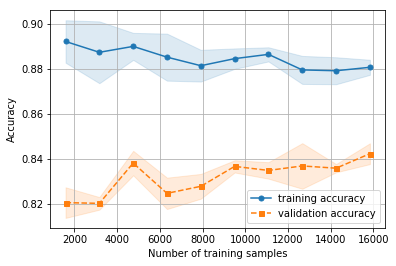

In [46]:
clf = KerasClassifier(build_keras_clf, **grid_search.best_params_)
train_sizes, train_scores, test_scores, train_mean, train_std, test_mean, test_std = gen_and_plot_learning_curve(clf, X_train_scaled, y_train, ylim=None, cv=4)